In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from scipy import stats
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
%matplotlib inline
from statsmodels.formula.api import ols
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


# Ignore Warning

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [51]:
df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/heart_failure_clinical_records_dataset.csv')

In [5]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [6]:
# Quick Inspection
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [7]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


# EDA

In [8]:
# univariate analysis - first we check the output variable and make sure it's balanced
# this step is needed when the problem is a multi-class classification problem
df_multi_class = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/Train.csv')
df_multi_class.groupby('Segmentation').count()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
Segmentation,,,,,,,,,,
A,1972,1972,1938,1972,1948,1939,1778,1972,1877,1953
B,1858,1858,1827,1858,1840,1836,1666,1858,1815,1845
C,1970,1970,1947,1970,1955,1952,1815,1970,1926,1949
D,2268,2268,2216,2268,2247,2217,1980,2268,2115,2245


<Axes: xlabel='Family_Size', ylabel='Count'>

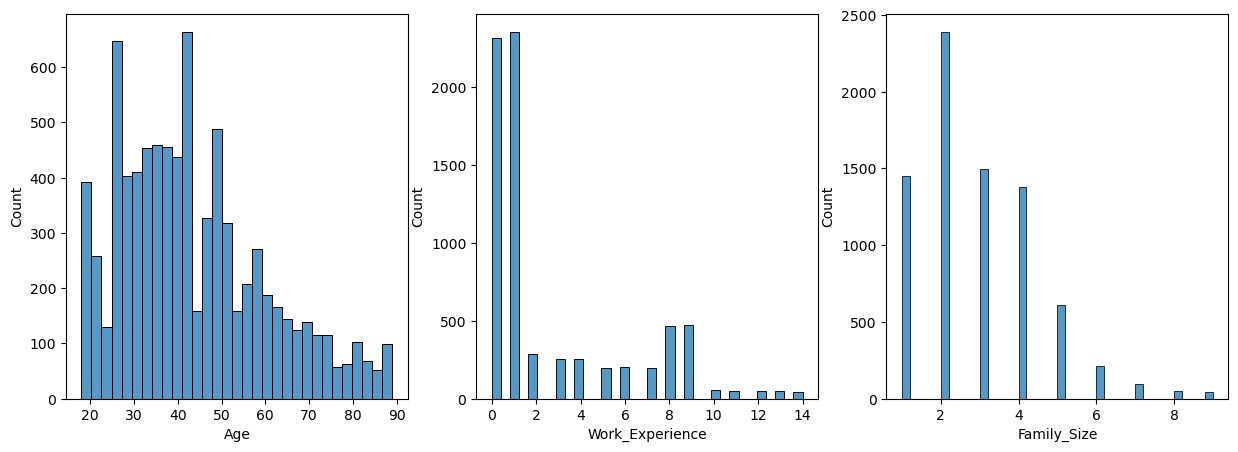

In [9]:
# check continuous variables distribution first: age, work experience, family size

import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
sns.histplot(df_multi_class['Age'], ax=ax1)
sns.histplot(df_multi_class['Work_Experience'], ax=ax2)
sns.histplot(df_multi_class['Family_Size'], ax=ax3)

<Axes: xlabel='Segmentation', ylabel='Family_Size'>

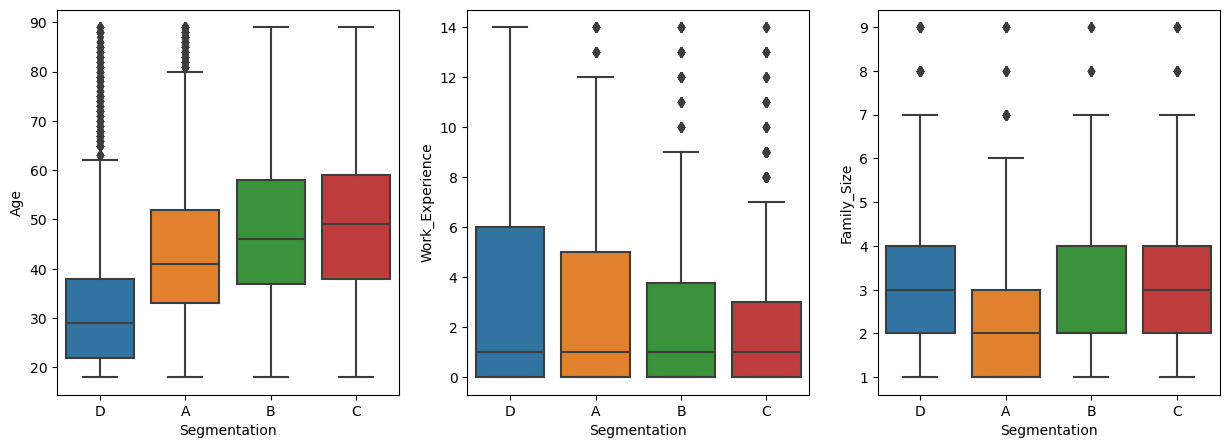

In [10]:
# check continuous variables: age, work experience, family size against the target variable

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
sns.boxplot(x='Segmentation',y='Age', data=df_multi_class, ax=ax1)
sns.boxplot(x='Segmentation',y='Work_Experience',data=df_multi_class, ax=ax2)
sns.boxplot(x='Segmentation',y='Family_Size', data=df_multi_class, ax=ax3)

Initial Hypothesis:

Age and work experience seem to be strong predictors of the segment as the interquartile ranges of segments are different within the age and work experience boxplots

In [11]:
# get the counts of gender (values being the row index) over segmentation (values being the columns)
df_multi_class.groupby(['Gender','Segmentation'])['ID'].count().unstack()

Segmentation,A,B,C,D
Gender,,,,
Female,909,861,922,959
Male,1063,997,1048,1309


In [12]:
# batch distribution checking
for i in ['Gender', 'Ever_Married','Graduated', 'Profession','Spending_Score']:
    print(df_multi_class.groupby([i,'Segmentation'])['ID'].count().unstack())
    print()

Segmentation     A    B     C     D
Gender                             
Female         909  861   922   959
Male          1063  997  1048  1309

Segmentation     A     B     C     D
Ever_Married                        
No             801   479   398  1607
Yes           1137  1348  1549   609

Segmentation     A     B     C     D
Graduated                           
No             729   508   348  1437
Yes           1219  1332  1607   810

Segmentation     A    B     C    D
Profession                        
Artist         558  756  1065  137
Doctor         199  143   140  206
Engineer       259  189    75  176
Entertainment  365  221   148  215
Executive      125  183   175  116
Healthcare     106  101   146  979
Homemaker       73   55    28   90
Lawyer         197  158   140  128
Marketing       57   30    35  170

Segmentation       A    B    C     D
Spending_Score                      
Average          343  590  903   138
High             271  384  405   156
Low             1358  8

In [13]:
df_multi_class[df_multi_class['Segmentation']=='D'].describe(include='all')

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
count,2268.000000,2268,2216,2268.000000,2247,2217,1980.000000,2268,2115.000000,2245,2268
unique,NaN,2,2,NaN,2,9,NaN,3,NaN,7,1
top,NaN,Male,No,NaN,No,Healthcare,NaN,Low,NaN,Cat_6,D
freq,NaN,1309,1607,NaN,1437,979,NaN,1974,NaN,1297,2268
mean,463380.026896,NaN,NaN,33.390212,NaN,NaN,3.021717,NaN,3.232624,NaN,NaN
std,2605.525629,NaN,NaN,15.680304,NaN,NaN,3.622962,NaN,1.693600,NaN,NaN
min,458985.000000,NaN,NaN,18.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN
25%,461069.750000,NaN,NaN,22.000000,NaN,NaN,0.000000,NaN,2.000000,NaN,NaN
50%,463130.500000,NaN,NaN,29.000000,NaN,NaN,1.000000,NaN,3.000000,NaN,NaN
75%,465733.250000,NaN,NaN,38.000000,NaN,NaN,6.000000,NaN,4.000000,NaN,NaN


#### transform categorical features into numeric features using one-hot encoding (dummy variables)

In [14]:
gender = pd.get_dummies(df_multi_class['Gender'], dtype=int )
print(gender.head())

Ever_Married = pd.get_dummies(df_multi_class['Ever_Married'], dtype=int)
Ever_Married.rename(columns={'Yes':"Married", "No":'Not_Married'},inplace=True)
print(Ever_Married.head())

Graduated = pd.get_dummies(df_multi_class['Graduated'], dtype=int)
Graduated.rename(columns={"Yes":"Graduated", "No":"Not_Graduated"}, inplace=True)
print(Graduated.head())

Profession = pd.get_dummies(df_multi_class['Profession'], dtype=int)
print(Profession.head())

Spending_score = pd.get_dummies(df_multi_class['Spending_Score'], dtype=int)
Spending_score

   Female  Male
0       0     1
1       1     0
2       1     0
3       0     1
4       1     0
   Not_Married  Married
0            1        0
1            0        1
2            0        1
3            0        1
4            0        1
   Not_Graduated  Graduated
0              1          0
1              0          1
2              0          1
3              0          1
4              0          1
   Artist  Doctor  Engineer  Entertainment  Executive  Healthcare  Homemaker  \
0       0       0         0              0          0           1          0   
1       0       0         1              0          0           0          0   
2       0       0         1              0          0           0          0   
3       0       0         0              0          0           0          0   
4       0       0         0              1          0           0          0   

   Lawyer  Marketing  
0       0          0  
1       0          0  
2       0          0  
3       1          

,Average,High,Low
0,0,0,1
1,1,0,0
2,0,0,1
3,0,1,0
4,0,1,0
...,...,...,...
8063,0,0,1
8064,0,0,1
8065,0,0,1
8066,0,0,1


In [15]:
df_multi_class = pd.concat([df_multi_class[['Age','Work_Experience','Family_Size']], # numeric variables
                            gender,Ever_Married, Graduated, Profession, Spending_score, df_multi_class['Segmentation']], axis=1)
df_multi_class

,Age,Work_Experience,Family_Size,Female,Male,Not_Married,Married,Not_Graduated,Graduated,Artist,...,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,Average,High,Low,Segmentation
0,22,1.0,4.0,0,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,D
1,38,NaN,3.0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,A
2,67,1.0,1.0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,B
3,67,0.0,2.0,0,1,0,1,0,1,0,...,0,0,0,0,1,0,0,1,0,B
4,40,NaN,6.0,1,0,0,1,0,1,0,...,1,0,0,0,0,0,0,1,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,22,0.0,7.0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,D
8064,35,3.0,4.0,0,1,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,D
8065,33,1.0,1.0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,D
8066,27,1.0,4.0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,B


 **As some models do not perform well on the granular categorical variables or categorical variables with imbalanced categorical values, we need to ensure the instances of categorical values in the categorical variables are balanced (so the model have enough info to capture patterns within any one category of a categorical variable, and will not be biased towards the dominant category) -> So you may need to combine some categories of a categorical variable into one to reduce the granularity of the categorical variables for better model training result**
 
### Note that Some models do not perform well due to the high variability of the categorical variables 

In [16]:
# One way to combine: 
# Combine low value users who are in segment A & D into one category, and high value users in segment B & C in another
# to convert the classification problem into binary classification
def recategorization(x):
    if x == 'A':
        return 0
    elif x == 'D':
        return 0
    elif x == 'B':
        return 1
    elif x =='C':
        return 1

df_multi_class['Segmentation'] = df_multi_class['Segmentation'].apply(recategorization)
df_multi_class

,Age,Work_Experience,Family_Size,Female,Male,Not_Married,Married,Not_Graduated,Graduated,Artist,...,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,Average,High,Low,Segmentation
0,22,1.0,4.0,0,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,38,NaN,3.0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,67,1.0,1.0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,1
3,67,0.0,2.0,0,1,0,1,0,1,0,...,0,0,0,0,1,0,0,1,0,1
4,40,NaN,6.0,1,0,0,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,22,0.0,7.0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8064,35,3.0,4.0,0,1,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
8065,33,1.0,1.0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
8066,27,1.0,4.0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,1


Another way to combine categories of a categorical variable:

In [17]:
mapping = {0:0, 1:1, 2:1, 3:1, 4:1}
df['hd_cons'] = df['hd'].map(mapping)

KeyError: 'hd'

### Multi-class evaluation (in case)
print("accuracy score: ",accuracy_score(pred, new_df.iloc[:,21])) 
print("f1 score weighted: ",f1_score(pred, new_df.iloc[:,21],average='weighted'))
print("precision score weighted: ",precision_score(pred, new_df.iloc[:,21],average='weighted'))
print("recall score weighted: ",recall_score(pred, new_df.iloc[:,21],average='weighted'))

# Back to original binary classification

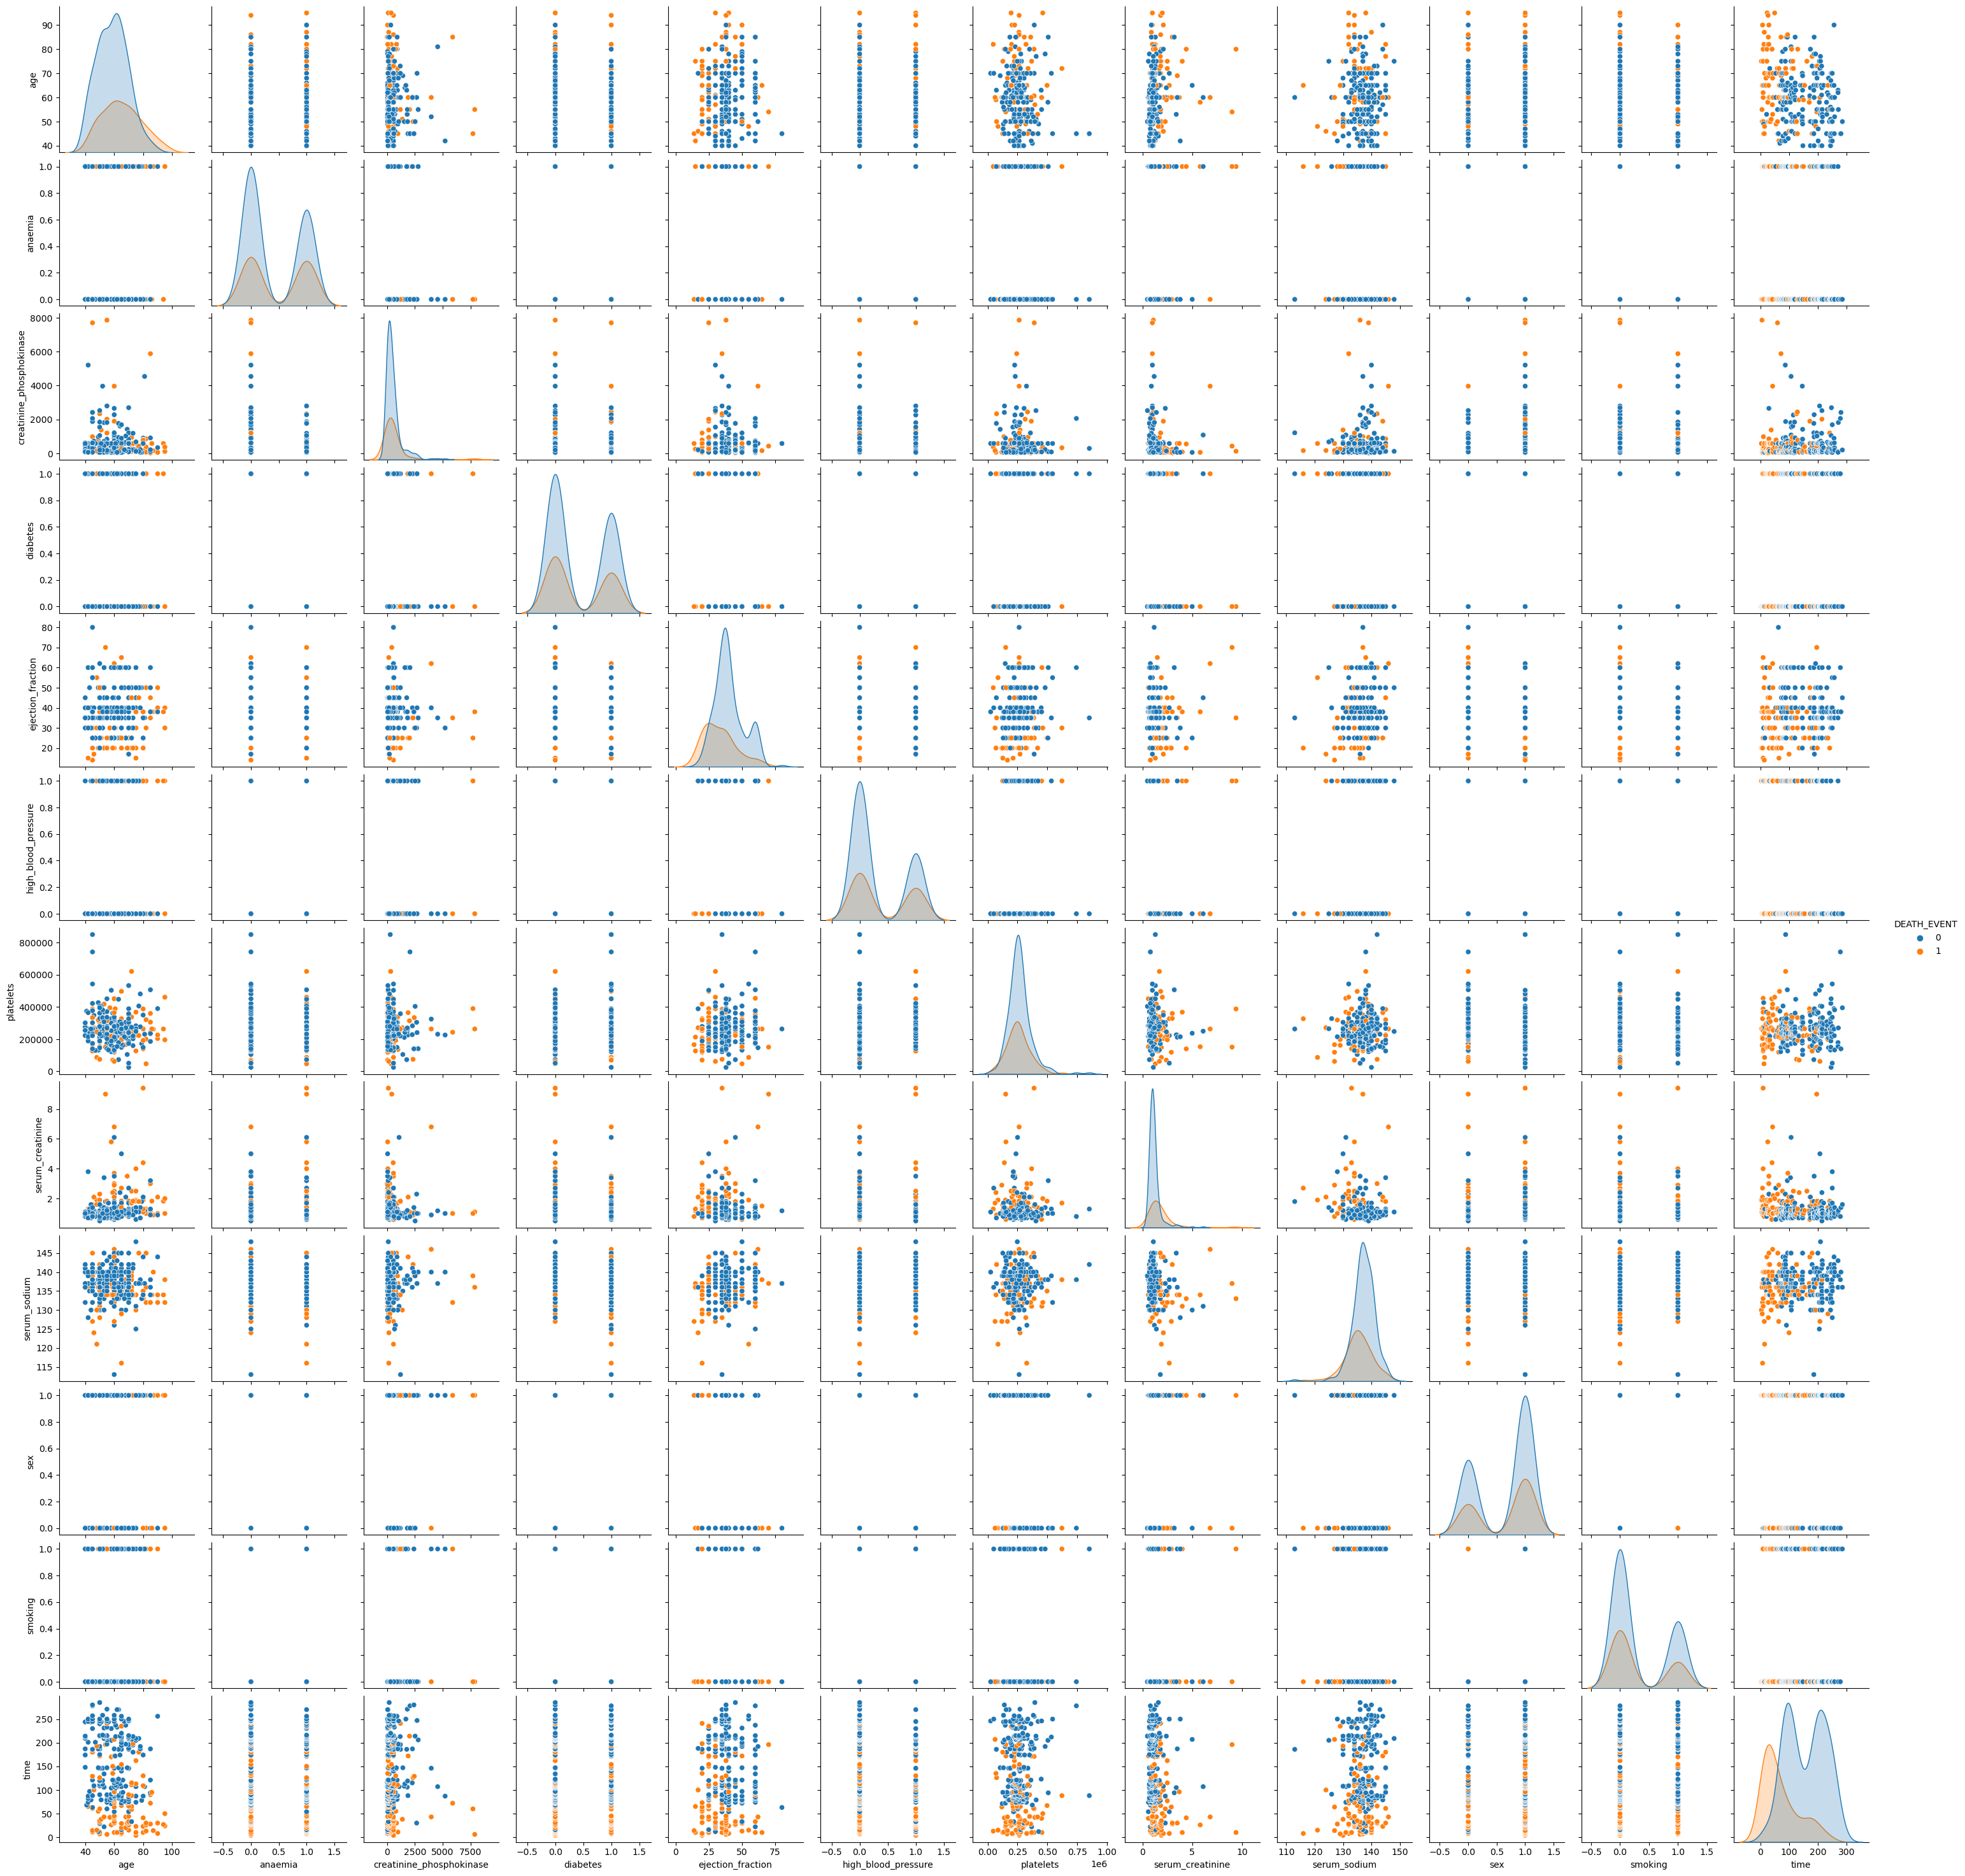

In [18]:
# fastest way to get all relational plots to find the features needed for investigations

sns.pairplot(df, hue='DEATH_EVENT')

# this is imbalanced dataset
# the first data plot show the count plot of age variable: x is the feature value, y is the count of feature values
# as indicated by the age vs age plot (the first plot): peak of death and non-death are around age 60, 
# and this plot indicates that the age values are normally distributed in this dataset



<Axes: xlabel='DEATH_EVENT', ylabel='age'>

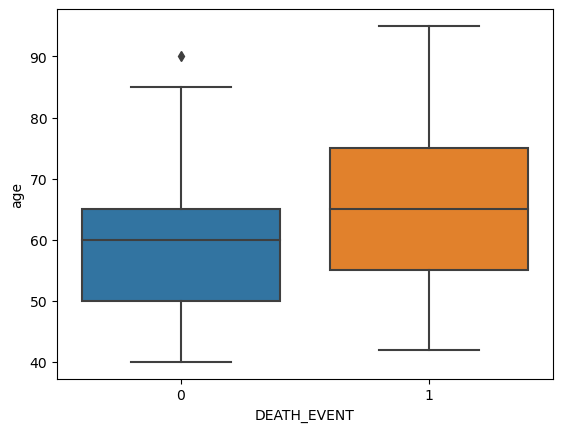

In [19]:
# investigate age feature first
sns.boxplot(x='DEATH_EVENT', y='age', data=df)
# people who are younger tend to not die
# and age gives some influence and should be included

<Axes: xlabel='DEATH_EVENT', ylabel='creatinine_phosphokinase'>

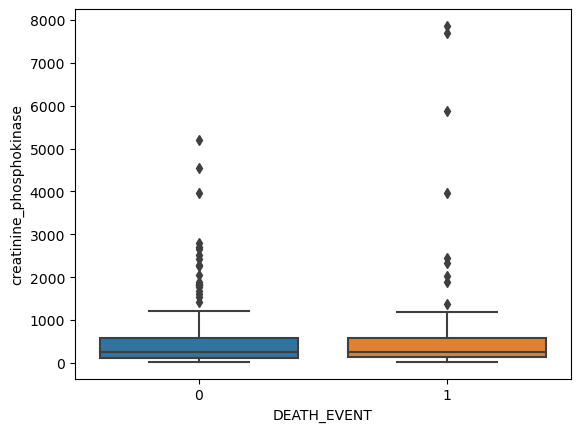

In [20]:
# feature 'creatinine_phosphokinase'
sns.boxplot(x='DEATH_EVENT', y='creatinine_phosphokinase', data=df)
# lots of outliers, let's remove them and see how the result is


<Axes: xlabel='DEATH_EVENT', ylabel='creatinine_phosphokinase'>

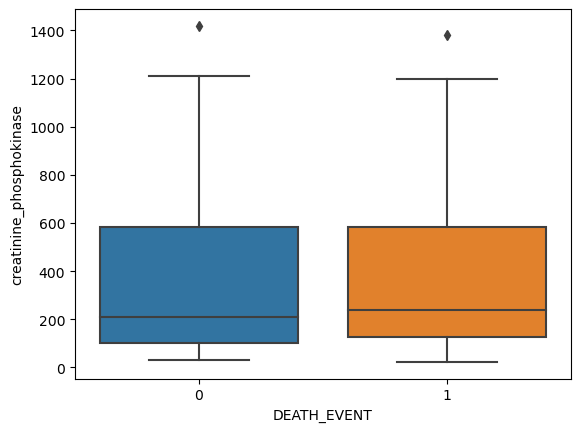

In [21]:
# Creatinine first
sns.boxplot(x='DEATH_EVENT', y='creatinine_phosphokinase', data=df[df['creatinine_phosphokinase']<=1500])
# below indicates that 'creatinine_phosphokinase' is not a very helpful variable for prediction and model training 
# as the majority of death (1) and non-death (0) data records have the same distribution  

<Axes: xlabel='DEATH_EVENT', ylabel='ejection_fraction'>

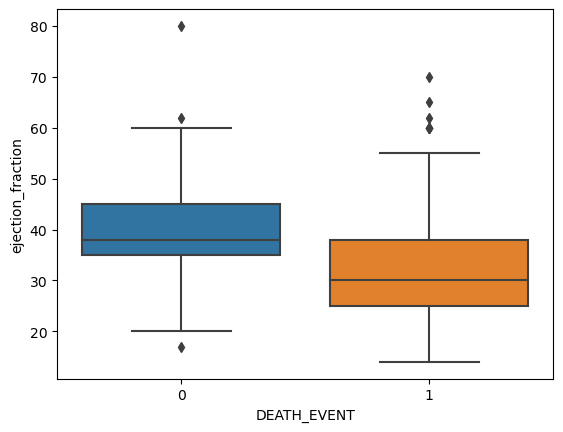

In [22]:
# Ejection Fraction (amount of blood heart pumps out each beat) first
# People who are not dead tends to have higher ejection_fraction, implying a useful / informative training feature
sns.boxplot(x='DEATH_EVENT', y='ejection_fraction', data=df)


<Axes: xlabel='DEATH_EVENT', ylabel='serum_creatinine'>

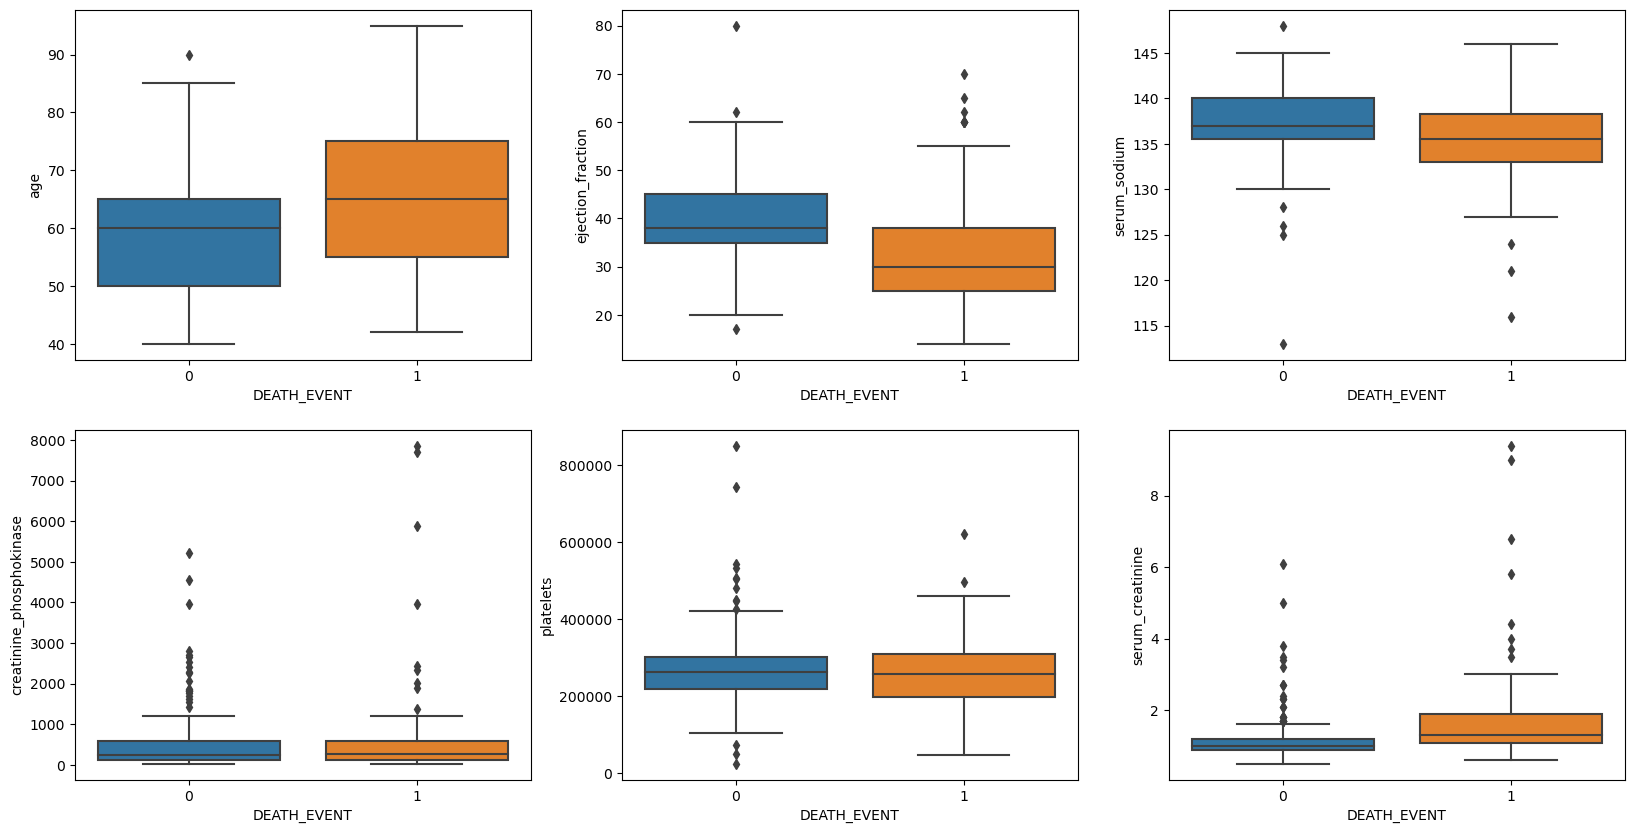

In [23]:
# create 6 subplots for 6 continuous variables

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,10))
sns.boxplot(x='DEATH_EVENT', y='age', ax=ax1, data=df)
sns.boxplot(x='DEATH_EVENT', y='ejection_fraction', ax=ax2, data=df)
sns.boxplot(x='DEATH_EVENT', y='serum_sodium', ax=ax3, data=df) # people who have less sodium tend to die
sns.boxplot(x='DEATH_EVENT', y='creatinine_phosphokinase', ax=ax4, data=df)
sns.boxplot(x='DEATH_EVENT', y='platelets', ax=ax5, data=df)
sns.boxplot(x='DEATH_EVENT', y='serum_creatinine', ax=ax6, data=df)

In [24]:
# initial hypothesis: age, serum_creatinine, serum_sodium, ejection_fraction are the most important continuous training features
# look at categoricals

df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [25]:
df_anaemia = df.groupby(['DEATH_EVENT','anaemia'])[['sex']].count()
df_anaemia # sex is used as the counting variable in this case (not distinguish male and female in this case)

sex
DEATH_EVENT anaemia     
0           0        120
            1         83
1           0         50
            1         46

In [26]:
# people who have anaemia are more likely to die, while people who do not have anaemia are more likely to survive,
# implying that this feature can be an informative feature for model training
# Also, the feature is not very balacned as the people who do not have anaemia outnumber the people who have anaemia

df_anaemia = df.groupby(['DEATH_EVENT','anaemia'])[['sex']].count().unstack()
df_anaemia['total'] = df_anaemia['sex'][0] + df_anaemia['sex'][1]
df_anaemia['percent_0'] = df_anaemia['sex'][0] / df_anaemia['total']
df_anaemia['percent_1'] = df_anaemia['sex'][1] / df_anaemia['total']
df_anaemia

sex     total percent_0 percent_1
anaemia        0   1                          
DEATH_EVENT                                   
0            120  83   203  0.591133  0.408867
1             50  46    96  0.520833  0.479167

In [27]:
# for diabetes: the proportion of people who die and not die is not related with whether the person has diabetes or not
# because people who are dead and people who are not dead have equal likelihood to have or not to have diabetes
# Note: 'sex' in this case is simply used as a counting variable to count the occurrence of death_event = 0 and diabetes = 0
# occurrence of death_event = 0 and diabetes = 1, and so on

df_diabetes = df.groupby(['DEATH_EVENT','diabetes'])[['sex']].count().unstack()
df_diabetes['total'] = df_diabetes['sex'][0] + df_diabetes['sex'][1]
df_diabetes['percent_0'] = df_diabetes['sex'][0] / df_diabetes['total']
df_diabetes['percent_1'] = df_diabetes['sex'][1] / df_diabetes['total']
df_diabetes

sex     total percent_0 percent_1
diabetes       0   1                          
DEATH_EVENT                                   
0            118  85   203  0.581281  0.418719
1             56  40    96  0.583333  0.416667

In [28]:
# people who have high_blood_pressure are more likely to die (as observed from percent_1 column), 
# while people who do not have high_blood_pressure are more likely to survive (as observed from percent_0 column),
# implying that this feature can be an informative feature for model training
df_high_blood_pressure = df.groupby(['DEATH_EVENT','high_blood_pressure'])[['sex']].count().unstack()
df_high_blood_pressure['total'] = df_high_blood_pressure['sex'][0] + df_high_blood_pressure['sex'][1]
df_high_blood_pressure['percent_0'] = df_high_blood_pressure['sex'][0] / df_high_blood_pressure['total']
df_high_blood_pressure['percent_1'] = df_high_blood_pressure['sex'][1] / df_high_blood_pressure['total']
df_high_blood_pressure

sex     total percent_0 percent_1
high_blood_pressure    0   1                          
DEATH_EVENT                                           
0                    137  66   203  0.674877  0.325123
1                     57  39    96  0.593750  0.406250

In [29]:
# people who are smoking (percent_1 column) have about equal liklihood to survive or to die
# while the people who are not smoking (percent_0 column) also have about the same liklihood to survive or to die
# implying a low importance of this feature in model training and predicting the target variable due to the little information / variance it provides

df_smoking = df.groupby(['DEATH_EVENT','smoking'])[['sex']].count().unstack()
df_smoking['total'] = df_smoking['sex'][0] + df_smoking['sex'][1]
df_smoking['percent_0'] = df_smoking['sex'][0] / df_smoking['total']
df_smoking['percent_1'] = df_smoking['sex'][1] / df_smoking['total']
df_smoking

sex     total percent_0 percent_1
smoking        0   1                          
DEATH_EVENT                                   
0            137  66   203  0.674877  0.325123
1             66  30    96  0.687500  0.312500

In [30]:
# Same conclusion with smoking can be drawn:
# people who are male (percent_1 column) have about equal liklihood to survive or to die
# while people who are female (percent_0 column) also have about equal liklihood to survive or to die
# implying a low importance of this feature in model training and predicting the target variable due to the little information / variance it provides

df_sex = df.groupby(['DEATH_EVENT','sex'])[['smoking']].count().unstack()
df_sex['total'] = df_sex['smoking'][0] + df_sex['smoking'][1]
df_sex['percent_0'] = df_sex['smoking'][0] / df_sex['total']
df_sex['percent_1'] = df_sex['smoking'][1] / df_sex['total']
df_sex


smoking      total percent_0 percent_1
sex               0    1                          
DEATH_EVENT                                       
0                71  132   203  0.349754  0.650246
1                34   62    96  0.354167  0.645833

In [31]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

# Train a random forest model or a logistic regression model to assess the feature importance 
But need to transform categorical features into numeric first


In [32]:
# covert numeric variables into categorical variables by one-hot encoding
dummies_season = pd.get_dummies(bikes.season, dtype=int)
dummies_season.rename(columns={1:'w',2:'spr', 3:'sum', 4:'fall'}, inplace=True)
df = pd.concat([df, dummies_season],axis=1)
df

NameError: name 'bikes' is not defined

Refined hypothesis: age, serum_creatinine, serum_sodium, ejection_fraction, aneimia, high_blood_pressure are most important

Build logistic regression on numeric features to know the feature importance 

#### **The data must be standardized before supplying to the logistic regression**
If features are on different scales, their corresponding coefficients in the logistic regression model are not directly comparable in terms of magnitude. By standardizing the features, the coefficients reflect the importance of each feature on the same scale.

Note that **all the training data are used in training the logistic regression** to generate the feature importance, because using the entire dataset can provide the most comprehensive view of the data and its inherent patterns. In other words, by leveraging all the available information, we can ensure that the feature coefficients (importances) reflect more accurate representations of how each feature impacts the model's decision-making process. 


In [52]:
log = LogisticRegression()
log.fit(df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking']], df['DEATH_EVENT'])


LogisticRegression()

In [53]:
# predict target variable
pred = log.predict(df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking']])

In [36]:
print("accuracy score: ", accuracy_score(pred,df['DEATH_EVENT']))
print("f1 score: ", f1_score(pred,df['DEATH_EVENT']))
print("precision score: ", precision_score(pred,df['DEATH_EVENT']))
print("recall score: ", recall_score(pred,df['DEATH_EVENT']))
print("roc auc score: ", roc_auc_score(pred,df['DEATH_EVENT']))



accuracy score:  0.7558528428093646
f1 score:  0.5100671140939597
precision score:  0.3958333333333333
recall score:  0.7169811320754716
roc auc score:  0.7406043871759471


As shown above, since the target variable is imbalanced, we should check f1 score as well (balancing recall and precision), high fp (low precision, predicting someone dead when they are not), and low fn (high recall, as recall = tp / (tp+fn) = % of positive cases have been correctly identified as positive). This means that the model identifies most of the positive cases but also making a substantial number of false positive errors.

The f1 score is only 51%, while roc auc score is 74%. The discrepancy between the low F1 score and the high ROC AUC score could be due to the threshold used for classification. The F1 score is calculated at a specific decision threshold (e.g., 0.5), whereas the ROC AUC considers all possible thresholds. Thus, this discrepancy may due to the fact that the chosen threshold for calculating the F1 score is not optimized, potentially leading to a low F1 score even when the model has good discriminative power.

Thus, though f1 score of the model is low (trade high fp for low fn), the model shows a overall good ability to differentiate between positive and negative classes (good roc_auc_score), implying good / acceptable model performance (so the feature importance generated by it should be reliable)

## Difference between F1 and ROC AUC:

F1 score focuses on the harmonic mean of precision and recall, primarily used for binary classification problems. In contrast, ROC AUC evaluates the model's ability to differentiate between the positive and negative classes across various thresholds.

## When to Use F1 Over ROC AUC:

While both metrics can be used for imbalanced datasets, F1 might be more informative when the positive class is rare or when false positives and false negatives have considerably different costs. (use f1 when the positive class is of specific interest)

### If you're specifically interested in the trade-off between precision and recall, then F1 is the metric to look at. If you're more concerned with the model's overall ability to differentiate between positive and negative classes, ROC AUC is more suitable.

If you're comparing multiple models, ROC AUC can be a good choice as it evaluates models across all thresholds, giving a broader view of model performance.

## Reliability of feature importance benefits from a well-performing model 
because it suggests that the model is capturing genuine patterns in the data, reflecting accurate feature importance
(namely the features that the model deems important are likely to be genuinely relevant to the target variable)

However, if the model is underfitting, the features that the model deems important may be contributing to its errors,
namely that the features that have high importances may not lead to higher accuracy, precision, or recall.

### Thus, the feature importances given by a under-performing model is not reliable, and should not be relied as the primary reference for feature selection 

### Relationship Between Performance and Feature Importance:

- Good Performance: If the model performs well, you can generally have more confidence that the feature importances it provides are meaningful. The model has learned the underlying patterns in the data, and the features that it deems important are likely to be genuinely relevant to the target variable.

- Poor Performance: If the model performs poorly, the feature importances may still provide insights, but they should be taken with caution. The model has not learned the underlying patterns well, and the features that it deems important may be contributing to its errors.

In [54]:
# larger coefficeint magnitude indicates higher importance 
feature_importance = pd.DataFrame(log.coef_.flatten(),index=log.feature_names_in_)
feature_importance.sort_values(0) # sort value based on column '0'


,0
ejection_fraction,-6.087321e-02
serum_sodium,-1.794820e-02
sex,-1.955147e-04
smoking,-1.310052e-04
platelets,-2.532455e-07
diabetes,2.845908e-05
creatinine_phosphokinase,2.021682e-04
anaemia,7.923522e-04
high_blood_pressure,8.707421e-04
serum_creatinine,6.279654e-03


As shown below, we can eliminate / remove the features with small magnitude like platelets, diabetes, etc, because we believe that the logistic regression model performance is satisfactory and so the feature importances generated by it can be used as a reference for feature selection

<Axes: >

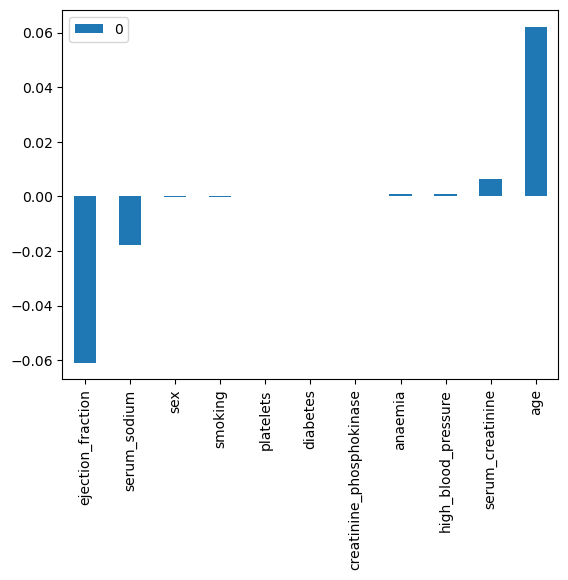

In [62]:
# feature importance in graph
feature_importance.sort_values(0).plot(kind='bar', rot=90)

### The above logistic regression can be considered as a baseline model to give an idea about if the problem is solvable, what are the feature importance, what is the minimal model performance we should expect, and what direction we should approach to solve the given problem.

Note: if you use stacking / ensemble method, ensure your estimator models are in the same type (i.e. probabilitic based, distance based) to minimize the variances in your prediction and yield better result.

Let's see the feature importance given by random forest

In [82]:
rf = RandomForestClassifier(n_estimators = 50,
                            min_samples_split = 5,
                            max_depth=6, 
                            random_state = 12) # avoid overfitting
rf.fit(df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking']], df['DEATH_EVENT'])

pred = rf.predict(df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking']])

print("accuracy score: ", accuracy_score(pred,df['DEATH_EVENT']))
print("f1 score: ", f1_score(pred,df['DEATH_EVENT']))
print("precision score: ", precision_score(pred,df['DEATH_EVENT']))
print("recall score: ", recall_score(pred,df['DEATH_EVENT']))
print("roc auc score: ", roc_auc_score(pred,df['DEATH_EVENT']))

accuracy score:  0.9096989966555183
f1 score:  0.8383233532934132
precision score:  0.7291666666666666
recall score:  0.9859154929577465
roc auc score:  0.9359402026192241


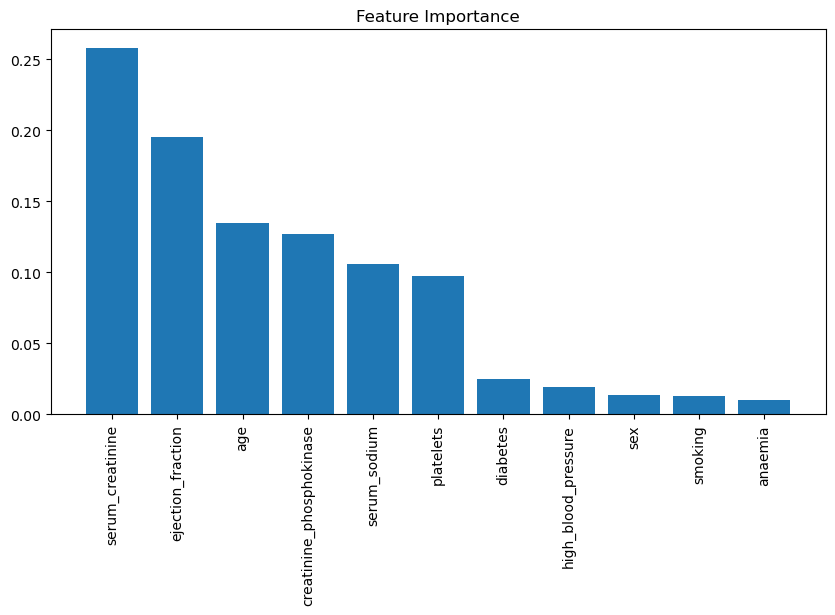

['serum_creatinine', 'ejection_fraction', 'age', 'creatinine_phosphokinase', 'serum_sodium', 'platelets', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'anaemia']
[0.25827681 0.1955112  0.13471481 0.12682866 0.10579508 0.09756597
 0.02480187 0.01962473 0.01340505 0.01302643 0.01044938]


In [83]:
# visualize results

# get the feature importance
importances = rf.feature_importances_
feature_names = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking']#X.columns

# Sort feature importances in descending order and get their indices
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 5))
plt.title("Feature Importance")
plt.bar(sorted_feature_names, importances[indices])
plt.xticks(sorted_feature_names, rotation=90)

plt.show()
print(sorted_feature_names)
print(importances[indices])

The feature importance generated by random forest is similar to the feature importances generated by the logistic regression in this case

In [38]:
# split the selected training features from the target variable
x = df[['age', 'anaemia','ejection_fraction', 'high_blood_pressure',
       'serum_creatinine', 'serum_sodium']]
y = df['DEATH_EVENT']

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1234)

In [40]:
knn = KNeighborsClassifier()
log = LogisticRegression()
nb = GaussianNB()
svc = SVC(kernel='linear')


In [41]:
knn.fit(x_train, y_train)
log.fit(x_train, y_train)
nb.fit(x_train, y_train)
svc.fit(x_train, y_train)

SVC(kernel='linear')

In [42]:
pred_knn = knn.predict(x_test)
pred_log = log.predict(x_test)
pred_nb = nb.predict(x_test)
pred_sv = svc.predict(x_test)

In [43]:
# the best performance is yielded by logistic regression and SVM
print(f1_score(pred_knn,y_test))
print(f1_score(pred_log,y_test))
print(f1_score(pred_nb,y_test))
print(f1_score(pred_sv,y_test))
# note that the svm result is weird if you use it as default as the f1 score is zero, 
# so we need to tune SVM's kernel function (in this case, use a linear kernel for it)

0.42424242424242425
0.6
0.4166666666666667
0.5714285714285714


# Model Selection 
Based on the model performance on the training set without tuning them, we can select the models that we want to investigate more and to optimize for

### Soft-Margin SVM
The "soft margin" SVM is achieved by allowing some of the data points to be misclassified or to fall within the margin. This is controlled by the C parameter in SVC. The C parameter determines the trade-off between maximizing the margin and minimizing the classification error:

-   A smaller value of C will result in a wider / **soft** margin, allowing some misclassifications, useful when the data is noisy or not linearly separable.
-   A larger value of C will aim for fewer misclassifications, resulting in a smaller / **hard** margin. (may not work well when data is not clearly separable)

Note: SVM is based on geometrical properties, not statistical properties (i.e., distance based, not probability based outcome like Bayes classifier)

In [44]:
# Focus on SVM and LogReg
# Find the best hyper-parameter for SVC
params_svc = {
    'C': range(1,10),
    'kernel' : ['rbf', 'linear','poly'],
    'degree': range(2,7)
}
randomsearch_svc = RandomizedSearchCV(svc,
                                      params_svc,
                                      cv=10,
                                      n_iter=15,
                                      scoring='f1')
randomsearch_svc.fit(x_train,y_train)

RandomizedSearchCV(cv=10, estimator=SVC(kernel='linear'), n_iter=15,
                   param_distributions={'C': range(1, 10),
                                        'degree': range(2, 7),
                                        'kernel': ['rbf', 'linear', 'poly']},
                   scoring='f1')

In [45]:
# note: linear kernel does not need degree as degree is only relevant to 'poly' kernel function
randomsearch_svc.best_params_


{'kernel': 'linear', 'degree': 5, 'C': 6}

In [46]:
log_pred_prob = log.predict_proba(x_test)
log_pred_prob
# column 0: prob of record being 0
# column 1: prob of record being 1

array([[0.86774117, 0.13225883],
       [0.80662151, 0.19337849],
       [0.74255348, 0.25744652],
       [0.79677647, 0.20322353],
       [0.47185531, 0.52814469],
       [0.47029164, 0.52970836],
       [0.70932025, 0.29067975],
       [0.8504059 , 0.1495941 ],
       [0.9832635 , 0.0167365 ],
       [0.82113433, 0.17886567],
       [0.75669579, 0.24330421],
       [0.97286609, 0.02713391],
       [0.63170614, 0.36829386],
       [0.42608937, 0.57391063],
       [0.63525883, 0.36474117],
       [0.942267  , 0.057733  ],
       [0.87374595, 0.12625405],
       [0.85125078, 0.14874922],
       [0.96966823, 0.03033177],
       [0.67231055, 0.32768945],
       [0.87019364, 0.12980636],
       [0.54541995, 0.45458005],
       [0.19226315, 0.80773685],
       [0.22222728, 0.77777272],
       [0.59084583, 0.40915417],
       [0.7938926 , 0.2061074 ],
       [0.62278785, 0.37721215],
       [0.76334095, 0.23665905],
       [0.76118693, 0.23881307],
       [0.8631043 , 0.1368957 ],
       [0.

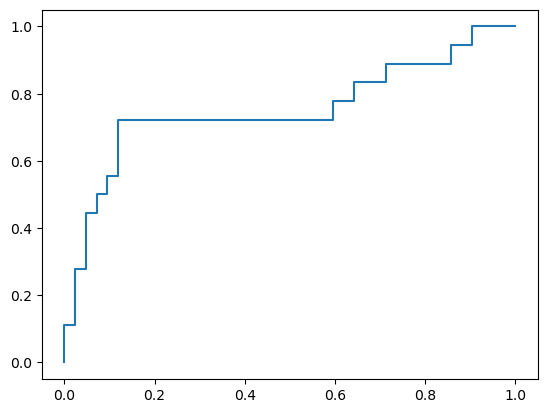

In [47]:
# plot the roc curve
fpr, tpr, tresholds = roc_curve(y_test,log_pred_prob[:,1])
plt.plot(fpr,tpr)

In [48]:
gmeans = np.sqrt(tpr*(1-fpr)) # find optimal threshold that maxmize the tpr and minimize the fpr
print("The probability threshold: ", tresholds[np.argmax(gmeans)])# the threshold
print("The correctness: ", np.max(gmeans)) # the correctness (showing the maximal tpr & minimal fpr corresponding to the above selected threshold)


The probability threshold:  0.3682938561738111
The correctness:  0.7976486609049038


In [49]:
# Get the f1 score of using the optimal prediction threshold (maximize tpr and minimize the fpr) 
y_pred_new = []
for i in log_pred_prob[:,1]:
  if i < 0.36829385617577914:
    y_pred_new.append(0)
  else:
    y_pred_new.append(1)

print(f1_score(y_pred_new,y_test))

0.6857142857142857


roc auc score with optimal threshold:  0.7831737346101231


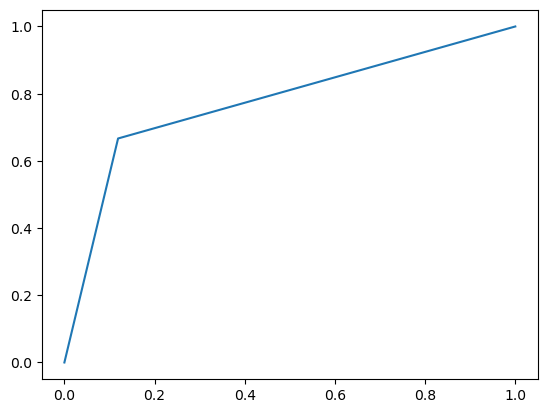

In [50]:
# roc curve by using the optimal prediction threshold
fpr, tpr, tresholds = roc_curve(y_test,y_pred_new)
print("roc auc score with optimal threshold: ",roc_auc_score(y_pred_new,y_test))
plt.plot(fpr,tpr)

# Bike Sharing Data 

In [51]:
bikes = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/bikes_sharing.csv')
bikes

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


Convert the continuous target variable into a categorical variable with 4 classes

Thus, the problem becomes a multi-class classification problem, rather than a regression problem

In [52]:
def casual_category(x):
    if x >= 0 and x <= 4:
        return 0
    elif x > 4 and x <= 17:
        return 1
    elif x >17 and x <= 49:
        return 2
    elif x > 49:
        return 3

bikes['casual_cat'] = bikes['casual'].apply(casual_category)
bikes.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_cat
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,0


In [53]:
# get training and testing set
x = np.array(bikes[['temp','humidity']])
y = np.array(bikes['casual_cat'])
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=123)

Use n=100 as we have multiple target values to predict 

Since the prediction of a record is based on the majority target label voting of the n nearest neighbours to the training record, the n nearest neighbour set needs to be large enough to produce meaningful and robust result when there are multiple target label values

Also, the 'nearest' is defined through the selected distance metric like Hamming or Euclidean distance 

In [54]:
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=100)

In [55]:
y_pred = knn.predict(x_test)
print("testing accuracy: ",accuracy_score(y_pred, y_test))

testing accuracy:  0.48438934802571165


Use grid search only when the training set is small or the # of hyper-parameter to tune is acceptable to avoid high computation cost & time 

Below we will use randomized search still

In [56]:
# params knn
params_knn = {'n_neighbors': list(range(1,500)), 
              'weights': ['uniform', 'distance'], 
              'metric': ['l1', 'euclidean', 'manhattan', 'sokalsneath', 'hamming', 'sokalmichener', 'rogerstanimoto', 'braycurtis', 'dice', 'jaccard', 'pyfunc', 'haversine', 'matching', 'cityblock', 'correlation', 'l2', 'nan_euclidean', 'chebyshev', 'p', 'wminkowski', 'minkowski', 'cosine', 'infinity', 'russellrao', 'seuclidean', 'canberra', 'kulsinski', 'sqeuclidean', 'yule', 'mahalanobis'] }
randomsearch_knn = RandomizedSearchCV(knn, params_knn, cv=10, n_iter=20, scoring='accuracy')
#gridsearch_knn = GridSearchCV(knn, params_knn, cv=10, scoring='roc_auc')

#gridsearch_knn.fit(x_train, y_train)
randomsearch_knn.fit(x_train, y_train)

#print("Best parameters from GridSearc: ", gridsearch_knn.best_params_)
print("Best parameters from RandomSearch: ", randomsearch_knn.best_params_)

Best parameters from RandomSearch:  {'weights': 'uniform', 'n_neighbors': 330, 'metric': 'sqeuclidean'}


In [57]:
# get the untrained / unfitted model with the optimal hyper-parameter set for the given task
knn_best = KNeighborsClassifier(**randomsearch_knn.best_params_)

# note that the model given to 'cross_val_score' should not be trained, as it has to be trained on the (k-1)-fold set
# and be tested against the 1-fold set
cv_scores_knn = cross_val_score(knn_best, x_train, y_train, cv=5, scoring='accuracy')
knn_best.fit(x_train, y_train)
y_pred_knn = knn_best.predict(x_test)

print(cv_scores_knn)
print("knn testing accuracy: ", accuracy_score(y_test, y_pred_knn))

[0.49827784 0.52009185 0.50574053 0.47846065 0.49396898]
knn testing accuracy:  0.485307621671258


# KNN and Naive Bayes

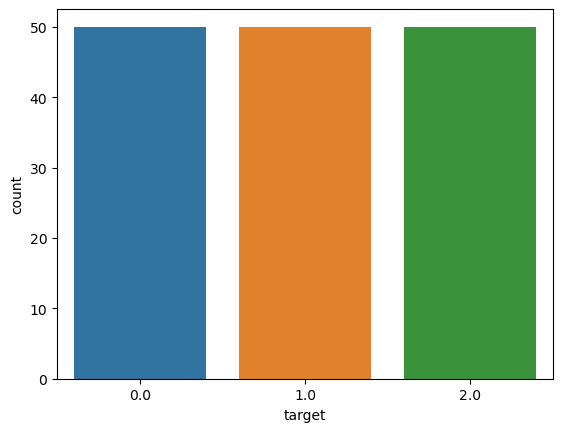

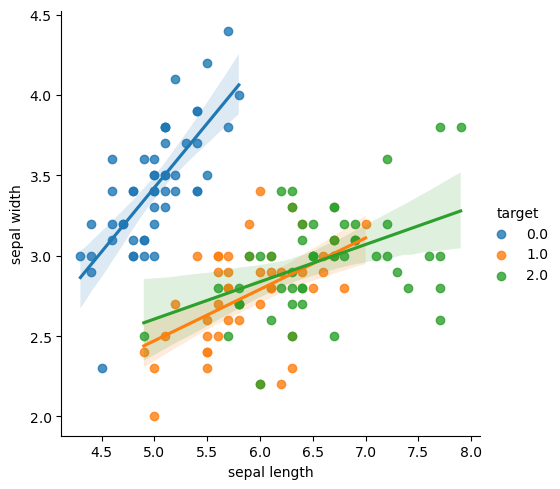

In [20]:
from sklearn.datasets import load_iris
iris = load_iris()
iris = pd.DataFrame(np.c_[iris['data'],iris['target']])
iris.rename(columns={0:'sepal length',1:'sepal width',2:'petal lenght', 3:'petal width', 4:'target'}, inplace=True)

# Display the distribution of the target variable 'Survived'
sns.countplot(x='target', data=iris)
plt.show()

# check the fitness of the data for KNN model (distance measure model)
sns.lmplot(x='sepal length',y='sepal width', data=iris, hue='target')

# Pipeline 

In [22]:
titan = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

# drop useless columns
titan.drop(['Ticket', 'Cabin'], axis=1, inplace=True)

# clean missing data
titan['Age'] = titan['Age'].fillna(titan.groupby('Sex')['Age'].transform('mean')) # filling age with by gender mean age
titan['Embarked'] = titan['Embarked'].fillna('S')


In [23]:
# separate numerical, categorical, and target variables
cat_columns = ['Pclass','Sex','Embarked']
num_columns = ['Age','SibSp','Parch','Fare']
target = 'Survived'

In [24]:
# build pipeline
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()
preprocessor = ColumnTransformer(transformers = [('cat',cat_transformer, cat_columns),
                                                 ('num', num_transformer, num_columns)])

#### Note: Never fit any other scaler or transformer on the testing set to let the testing set actually simulates the real-world scenario 
Since in real-world scenarios, we won't have access to future data (analogous to the test set) when developing and deploying a model, any preprocessing, including scaling, should be determined solely based on the available data (analogous to the training set).

In [45]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(titan[cat_columns + num_columns], 
                                                    titan[target], test_size=0.2, random_state=42)

x_train_transformed = preprocessor.fit_transform(X_train)
x_test_transformed = preprocessor.transform(X_test)

In [27]:
encoded_columns = list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_columns))
all_feat = num_columns + encoded_columns

X_train_transformed = pd.DataFrame(x_train_transformed, columns=all_feat)
X_test_transformed = pd.DataFrame(x_test_transformed, columns=all_feat)


#### Get the accuracy plot of knn by tuning the number of neighbours
As shown below, n should not go beyond 50 as the accuracy score drops after 50 and hardly come back 

Note: Always tune the k hyper-parameter and always set the **k to be an odd number** to avoid cases when the # of neighbour records with different class label are the same (as the model just randomly assigns a label to the training record in such case)

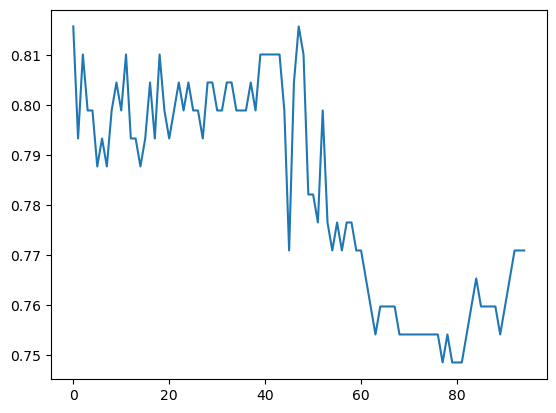

In [30]:
import warnings
warnings.filterwarnings("ignore")
acc= []
for i in range(5,100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train_transformed,y_train)
    pred= knn.predict(X_test_transformed)
#    print(f1_score(pred,y_test))
    acc.append(accuracy_score(pred,y_test))
plt.plot(acc)



#### Randomized search cv and grid search cv for hyper-parameter tuning

In [34]:
# Hyperparameter Tuning
# select parameters
params_nb = {'var_smoothing': np.logspace(0,-9, num=100)}
params_knn = {'n_neighbors': list(range(1,50)), 
              'weights': ['uniform', 'distance'], 
              'metric': ['l1', 'euclidean', 'manhattan', 'sokalsneath', 'hamming', 'sokalmichener', 'rogerstanimoto', 'braycurtis', 'dice', 'jaccard', 'pyfunc', 'haversine', 'matching', 'cityblock', 'correlation', 'l2', 'nan_euclidean', 'chebyshev', 'p', 'wminkowski', 'minkowski', 'cosine', 'infinity', 'russellrao', 'seuclidean', 'canberra', 'kulsinski', 'sqeuclidean', 'yule', 'mahalanobis'] }

# Define the models
nb = GaussianNB()
knn = KNeighborsClassifier()

# Define GridSearchCV
gridsearch_nb = GridSearchCV(nb, params_nb, cv=10,scoring='roc_auc')
randomsearch_knn = RandomizedSearchCV(knn, params_knn, cv=10, scoring='roc_auc')

# Fit models
gridsearch_nb.fit(X_train_transformed, y_train)
randomsearch_knn.fit(X_train_transformed, y_train)

# Get the best parameters
print("Best parameters for Naive Bayes: ", gridsearch_nb.best_params_)
print("Best parameters for KNN: ", randomsearch_knn.best_params_)

Best parameters for Naive Bayes:  {'var_smoothing': 0.43287612810830584}
Best parameters for KNN:  {'weights': 'uniform', 'n_neighbors': 13, 'metric': 'l1'}


In [35]:
# Apply the best parameters to the untrained models
nb_best = GaussianNB(**gridsearch_nb.best_params_) # '**' indicates keyword argument (treat the supplied dictionary as an argument list)
knn_best = KNeighborsClassifier(**randomsearch_knn.best_params_)

# Perform cross-validation
cv_scores_nb = cross_val_score(nb_best, X_train_transformed, y_train, cv=5, scoring='roc_auc')
cv_scores_knn = cross_val_score(knn_best, X_train_transformed, y_train, cv=5, scoring='roc_auc')

print("Cross-validation scores for Naive Bayes: ", cv_scores_nb)
print("Cross-validation scores for KNN: ", cv_scores_knn)

# Fit the models with the best parameters
nb_best.fit(X_train_transformed, y_train)
knn_best.fit(X_train_transformed, y_train)

# Evaluate on the test set
y_pred_nb = nb_best.predict(X_test_transformed)
y_pred_knn = knn_best.predict(X_test_transformed)

print("Test accuracy for Naive Bayes: ", accuracy_score(y_test, y_pred_nb))
print("Test accuracy for KNN: ", accuracy_score(y_test, y_pred_knn))

Cross-validation scores for Naive Bayes:  [0.85996671 0.82594673 0.84142463 0.77962688 0.86447811]
Cross-validation scores for KNN:  [0.86839367 0.85351644 0.82923468 0.8253127  0.86710859]
Test accuracy for Naive Bayes:  0.7318435754189944
Test accuracy for KNN:  0.8044692737430168


In [37]:
# Compute metrics
print("Naive Bayes Metrics: ")
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_nb))
print("Accuracy: ", accuracy_score(y_test, y_pred_nb))
print("Precision: ", precision_score(y_test, y_pred_nb))
print("Recall: ", recall_score(y_test, y_pred_nb))
print("F1 Score: ", f1_score(y_test, y_pred_nb))

print("\nK-Nearest Neighbors Metrics: ")
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_knn))
print("Accuracy: ", accuracy_score(y_test, y_pred_knn))
print("Precision: ", precision_score(y_test, y_pred_knn))
print("Recall: ", recall_score(y_test, y_pred_knn))
print("F1 Score: ", f1_score(y_test, y_pred_knn))

Naive Bayes Metrics: 
Confusion Matrix: 
 [[96  9]
 [39 35]]
Accuracy:  0.7318435754189944
Precision:  0.7954545454545454
Recall:  0.47297297297297297
F1 Score:  0.5932203389830508

K-Nearest Neighbors Metrics: 
Confusion Matrix: 
 [[96  9]
 [26 48]]
Accuracy:  0.8044692737430168
Precision:  0.8421052631578947
Recall:  0.6486486486486487
F1 Score:  0.7328244274809161


# Decision Tree

In [59]:
df_tree = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', 
                  header=None)
df_tree.columns = ['age','sex','cp','restbp','chol','fbs', 'restecg','thalach','exang','oldpeak','slope','ca','thal','hd']
df_tree

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


IF missing values are indicated by '?' and the # of records with the missing signs is < 10% of total records, just drop them by using below code:

In [60]:
to_drop = list(df_tree[df_tree['ca']=='?'].index.values) + list(df_tree[df_tree['thal']=='?'].index.values) # get the index list to drop records
df_tree.drop(to_drop, axis=0, inplace=True) # indicate drop by index of rows rather than column names

In [61]:
# conver the 'ca' and 'thal' categorical features back into numeric
df_tree['ca'] = pd.to_numeric(df_tree['ca'])
df_tree['thal'] = pd.to_numeric(df_tree['thal'])
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      297 non-null    float64
 1   sex      297 non-null    float64
 2   cp       297 non-null    float64
 3   restbp   297 non-null    float64
 4   chol     297 non-null    float64
 5   fbs      297 non-null    float64
 6   restecg  297 non-null    float64
 7   thalach  297 non-null    float64
 8   exang    297 non-null    float64
 9   oldpeak  297 non-null    float64
 10  slope    297 non-null    float64
 11  ca       297 non-null    float64
 12  thal     297 non-null    float64
 13  hd       297 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.8 KB


As shown below, the people who either have high blood sugar (feature 'fbs' = 1) or not have are both likely to have no 
heart disease (hd). 

This implies that the blood sugar may not be a good predictive feature because the people who have high blood sugar share similar hd distribution with the people who do not have

Meanwhile, the number of records with 'fbs' = 1 is small (fbs feature value is dominated by 0), meaning that 
there is not enough info to train the model to learn the underlying patterns (the model will be biased towards records with 'fbs' = 0) 

thus this feature provides more noises than values for the model learning

fbs  0.0  1.0
hd           
0    137   23
1     51    3
2     27    8
3     27    8
4     12    1


<Axes: xlabel='hd'>

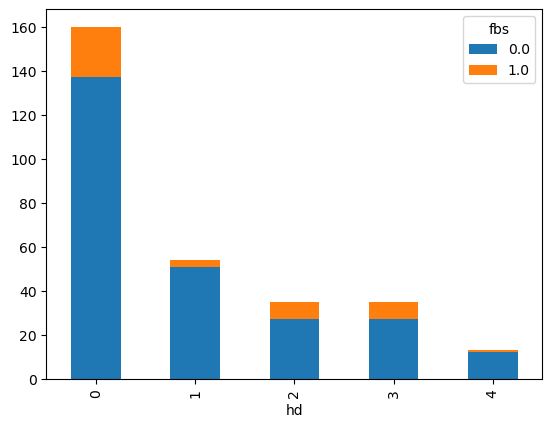

In [62]:
print(df_tree.groupby(['hd','fbs'])['thal'].count().unstack()) 
df_tree.groupby(['hd','fbs'])['thal'].count().unstack().plot(kind='bar', stacked=True)


thal  3.0  6.0  7.0
hd                 
0     127    6   27
1      22    3   29
2       7    6   22
3       6    1   28
4       2    2    9


<Axes: xlabel='hd'>

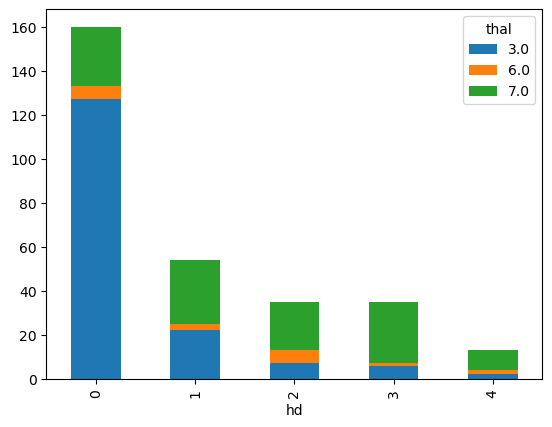

In [63]:
# visualize the groupby
print(df_tree.groupby(['hd','thal'])['ca'].count().unstack())
df_tree.groupby(['hd','thal'])['ca'].count().unstack().plot(kind='bar', stacked=True)

In [64]:
mapping = {0:0, 1:1, 2:1, 3:1, 4:1}
df_tree['hd_cons'] = df_tree['hd'].map(mapping)
df_tree

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd,hd_cons
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1


In [65]:
X = df_tree.iloc[:,:13] # select all records with the first 13 columns
Y = df_tree.iloc[:, 13]
X

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0


In [66]:
Y_v2 = df_tree.iloc[:,14]
Y_v2 # get the transformed binary target variable

0      0
1      1
2      1
3      0
4      0
      ..
297    1
298    1
299    1
300    1
301    1
Name: hd_cons, Length: 297, dtype: int64

### Why get dummy variable for model training when the categorical variable is like 1,2,3...
Because, if the values of a categorical variable is in ordinal scale (rank categorical variable) that has meaningful distance between each categorical value, then we can use this **rank categorical variables** as continuous variable without one-hot encoding (i.e. age). IN short, ordinal numerical variables have a natural order and the ordinal variable values have a meaningful progression, so the ordinal numerical variables can be directly used in most ML algorithms without the need for one-hot encoding.

However, if the categorical values have no meaningful distance between each other, then it is non-sensical to treat them as continuous variables (i.e. country code) from an interpretability perspective

### belows shows how to get all dummy categorical variables at one time 

In [67]:
# get all dummy categorical variables at one time 
cat_columns = ['sex','cp','restecg','slope','ca','thal','exang','fbs']
X_encoded = pd.get_dummies(X, columns=cat_columns, dtype=int)
X_encoded

,age,restbp,chol,thalach,oldpeak,sex_0.0,sex_1.0,cp_1.0,cp_2.0,cp_3.0,...,ca_1.0,ca_2.0,ca_3.0,thal_3.0,thal_6.0,thal_7.0,exang_0.0,exang_1.0,fbs_0.0,fbs_1.0
0,63.0,145.0,233.0,150.0,2.3,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,1
1,67.0,160.0,286.0,108.0,1.5,0,1,0,0,0,...,0,0,1,1,0,0,0,1,1,0
2,67.0,120.0,229.0,129.0,2.6,0,1,0,0,0,...,0,1,0,0,0,1,0,1,1,0
3,37.0,130.0,250.0,187.0,3.5,0,1,0,0,1,...,0,0,0,1,0,0,1,0,1,0
4,41.0,130.0,204.0,172.0,1.4,1,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,140.0,241.0,123.0,0.2,1,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
298,45.0,110.0,264.0,132.0,1.2,0,1,1,0,0,...,0,0,0,0,0,1,1,0,1,0
299,68.0,144.0,193.0,141.0,3.4,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,1
300,57.0,130.0,131.0,115.0,1.2,0,1,0,0,0,...,1,0,0,0,0,1,0,1,1,0


### Draw a decision tree by setting the hyper-parameters (pruning) of the tree to avoid over-fitting and preserve interpretability

min_samples_leaf = 5 means that each leaf node should have at least 5 records (if the leaf node cannot have 5 records, the splitting should not be performed)

**min_samples_split** concerns the act of splitting an internal node:  If the number of samples in a node is below min_samples_split, the node will not be split further and will become a leaf node. This helps in controlling the depth of the tree. Larger values make the tree shallower by restricting splits on nodes with small sample sizes.


**min_samples_leaf** concerns the resulting leaves after a split: If a potential split results in a leaf node that has fewer samples than min_samples_leaf, then the split will not be carried out. Instead, this node will remain a leaf node with its current samples. This helps in preventing tiny splits that capture noise in the data.

Those hyper-parameters need to be set as a tree that is too deep and has leaves with very few samples might be capturing noise in the training data. By setting these parameters to values greater than the default of 2, we can make the model more generalized and robust against overfitting. 

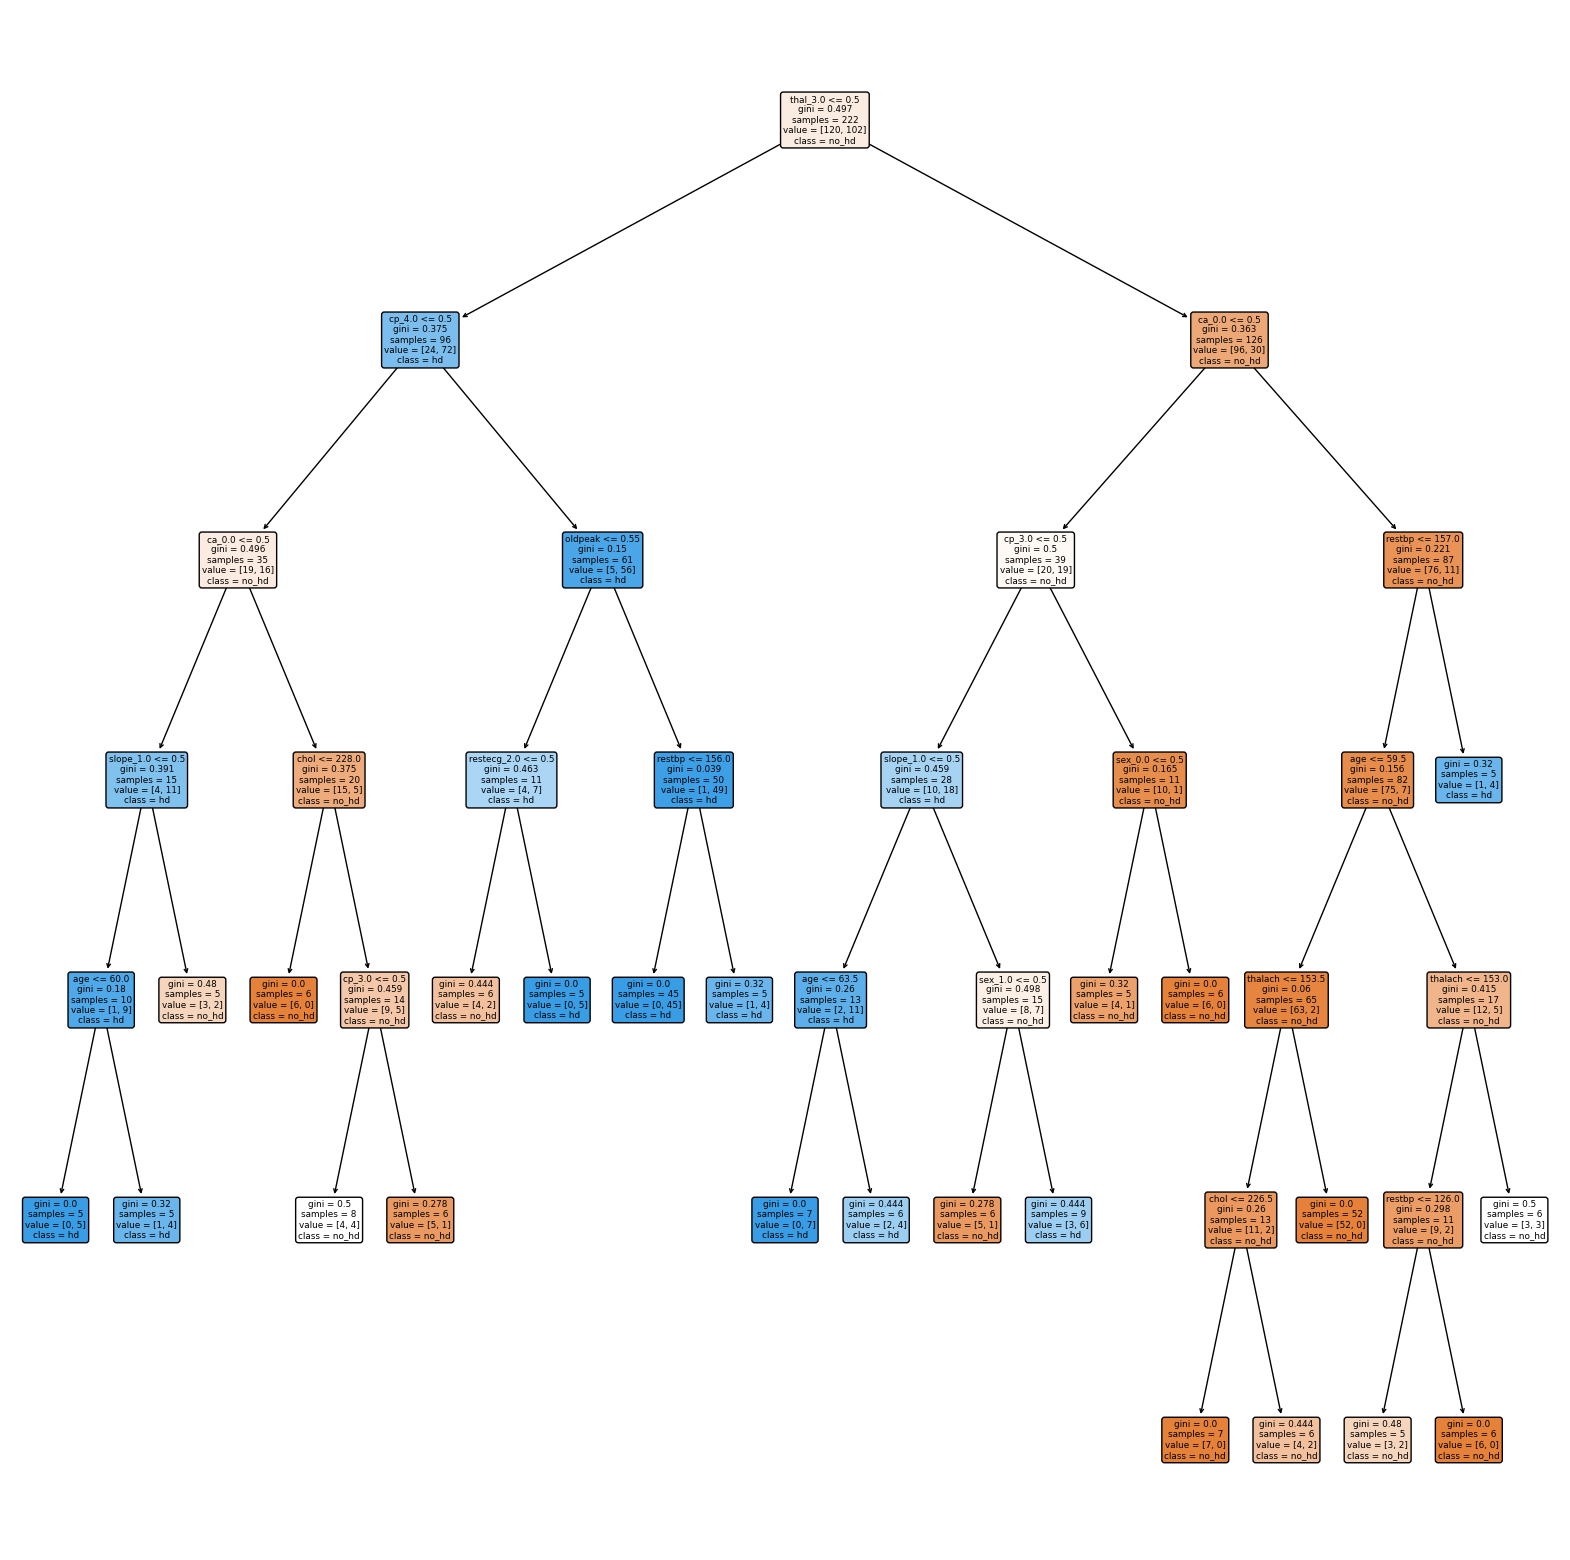

In [68]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_encoded, Y_v2, random_state=123)
dt_v3 = DecisionTreeClassifier(random_state=123, max_depth = 6, min_samples_leaf = 5)

dt_v3 = dt_v3.fit(X_train3, y_train3)
plt.figure(figsize=(20,20))
plot_tree(dt_v3, filled=True, rounded=True, class_names=['no_hd','hd'], feature_names=X_encoded.columns.tolist());


The colour indciates the class label and the lightness of the colour indicates the purity of the node (the darker the colour, the more pure the node)

### Get the decision tree performance and see if it can be improved by using a different technique for splitting

In [69]:
# original decision tree performance
dt_v3 = DecisionTreeClassifier(random_state=123, max_depth = 6, min_samples_leaf = 5)
dt_v3 = dt_v3.fit(X_train3, y_train3)
predicted_train = dt_v3.predict(X_train3)
predicted_test = dt_v3.predict(X_test3)
print('train accuracy: ', accuracy_score(predicted_train, y_train3))
print('test accuracy: ', accuracy_score(predicted_test, y_test3))

train accuracy:  0.8828828828828829
test accuracy:  0.8266666666666667


'Entropy' is used as the splitting technique 

Apparently the model is experiencing overfitting as the train accuracy is much higher (10% higher) than the test accuracy. 

In [70]:
dt_v3 = DecisionTreeClassifier(random_state=123, 
                               max_depth = 6, 
                               min_samples_leaf = 5,
                               criterion='entropy')
dt_v3 = dt_v3.fit(X_train3, y_train3)
predicted_train = dt_v3.predict(X_train3)
predicted_test = dt_v3.predict(X_test3)
print('train accuracy: ', accuracy_score(predicted_train, y_train3))
print('test accuracy: ', accuracy_score(predicted_test, y_test3))

train accuracy:  0.8783783783783784
test accuracy:  0.7733333333333333


In [71]:
# 'log_loss' used as the splitting technique (similar performance with entropy splitting technique)
dt_v3 = DecisionTreeClassifier(random_state=123, 
                               max_depth = 6, 
                               min_samples_leaf = 5,
                               criterion='log_loss')
dt_v3 = dt_v3.fit(X_train3, y_train3)
predicted_train = dt_v3.predict(X_train3)
predicted_test = dt_v3.predict(X_test3)
print('train accuracy: ', accuracy_score(predicted_train, y_train3))
print('test accuracy: ', accuracy_score(predicted_test, y_test3))

train accuracy:  0.8783783783783784
test accuracy:  0.7733333333333333


### Reason why the tree using the 'entropy' criterion have a larger gap between training and test accuracy, indicating a higher degree of overfitting compared to the tree using the Gini criterion (both trees have the same hyper-parameter)

Entropy is generally more sensitive than the Gini index. This means that when making splits, a tree using entropy might make more fine-grained decisions, capturing noise in the training data, and leading to higher degree of overfitting.

Nature of the Data: The inherent properties and distribution of the data might favor one criterion over the other. There might be certain patterns or structures in the data that get captured differently by Gini and entropy.

# Statistical Testing (Experimentation)

In [72]:
exp = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/experiment_demo_dataset.csv')
exp.drop('Unnamed: 0', axis=1, inplace = True)
exp.set_index('User ID', inplace=True)
exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1000 non-null   int64  
 1   Device Type                1000 non-null   object 
 2   Location                   1000 non-null   object 
 3   Average Spend              1000 non-null   float64
 4   Average Play Time          1000 non-null   float64
 5   Average Time Watching Ads  1000 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 54.7+ KB


Before we design the experiment, we need to make sure that the users behaviours are not affected by certain characteristics. 

This means that users 'Location', 'Device Type' and 'Age' shouldn't affect the amounts of money they spend, time they spend playing games, or time they spend watching ads. We can use statistical tests to support our analysis.

In [73]:
# check user's features by location, which seems to be similar across different locations
exp.groupby('Location')[['Average Spend','Average Play Time','Average Time Watching Ads']].mean()

,Average Spend,Average Play Time,Average Time Watching Ads
Location,,,
Location1,51.144352,5.093330,1.503598
Location2,51.752892,5.062008,1.453953
Location3,50.563795,4.952144,1.498298


Let's use an ANOVA test to validate each metric. If they are statistically the same, then they should have a HIGH p-value.

As the two p values are > 0.05, we can conclude that for all 3 locations and all 3 device types, the users behave the same. There is no statistically significant difference between their average spend, meaning that we can comfortably assign all users to any variant of our experiment.


In [74]:
# checking Location vs spend
loc_1 = exp[exp['Location'] == 'Location1']['Average Spend']
loc_2 = exp[exp['Location'] == 'Location2']['Average Spend']
loc_3 = exp[exp['Location'] == 'Location3']['Average Spend']

p_val = stats.f_oneway(loc_1, loc_2, loc_3)
print("p-value of locations vs average spend: ", p_val[1])


p-value of locations vs average spend:  0.8637488343476756


In [75]:
# checking Device vs spend
loc_1 = exp[exp['Device Type'] == 'Device1']['Average Spend']
loc_2 = exp[exp['Device Type'] == 'Device2']['Average Spend']
loc_3 = exp[exp['Device Type'] == 'Device3']['Average Spend']

p_val = stats.f_oneway(loc_1, loc_2, loc_3)
print("p-value of device type vs average spend: ", p_val[1])

p-value of device type vs average spend:  0.9698997074210355


Note, we can see a much lower p-value on device type vs Average Play Time, though the value is still above 0.05. To be safe though, perhaps we won't do an experiment which seeks to influence Play Time. Since there are differences in behaviour between people who have different devices, if we run an experiment, we won't be able to attribute the change in behaviour to the experiment. Our results won't be reliable. So, with this user group we should focus on feature changes which could impact Averaage Time Watching Ads or Average Spend.

## Experiment Design

Since we identified the risk of experimenting with Play Time as we do see SOME difference by device type, we can pick between Increasing Average Spend or Increasing Avg Time Spent Watching Ads.

Let's take Average Spend. Suppose we introduced a new notification type which offered users a % discount on their next in-app purchase. Perhaps we want to offer some users 10% off and other users 20% off to see which discount works best. We should now divide our data set into 3 sections: **Variant 1 - 10% off; Variant 2 - 20% off, and Control - no discount**. After the experiment, we will review the results.

We can use pandas' sample() function to select subsets of users, or simply select the first 300 for Variant 1, the second 300 for Variant 2 and the last 400 for Control.

In [76]:
# Variant 1 - 10% off - 30% of users
variant1 = exp.iloc[0:300]

# Variant 2 - 20% off - 30% of users
variant2 = exp.iloc[300:600]

# Control group - no discount
control = exp.iloc[600:]

# Create a new label column to serve as the variant identifier
variant1['Variant'] = 'Variant 1'
variant2['Variant'] = 'Variant 2'
control['Variant'] = 'Control'

# Concatenate all 3 data sets horizontally
final_dataset = pd.concat([variant1, variant2, control], axis=0)
final_dataset

,Age,Device Type,Location,Average Spend,Average Play Time,Average Time Watching Ads,Variant
User ID,,,,,,,
1,62,Device3,Location3,54.608937,0.234102,2.262157,Variant 1
2,65,Device1,Location1,36.428457,0.802944,1.440160,Variant 1
3,18,Device1,Location2,84.843851,4.349362,0.374079,Variant 1
4,21,Device3,Location1,30.963386,5.966833,2.430972,Variant 1
5,21,Device3,Location2,76.392755,9.401406,1.041962,Variant 1
...,...,...,...,...,...,...,...
996,54,Device1,Location3,77.823025,7.265630,1.881264,Control
997,19,Device1,Location3,27.422427,9.863676,1.798216,Control
998,47,Device2,Location1,28.934192,2.449896,2.218613,Control


## Analyzing Experiment Results

Now let's suppose that we ran the experiment over 2 weeks, and we now have a new data set with 3 new columns:
* Post_Test_Avg_Spend = this looks at the average spend per user after the discount test
* Post_Test_Avg_Play-Time = this looks at the average time spent playing games by users after the discount test
* Post_Test_Avg_Time_Watching_Ads = this looks at the average time spent watching ads after the discount test

Let's import the data.

In [77]:
results = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/experiment_demo_dataset_results.csv')
results.head()

,User ID,Age,Device Type,Location,Average Spend,Average Play Time,Average Time Watching Ads,Variant,Post_Test_Avg_Spend,Post_Test_Avg_Play_Time,Post_Test_Avg_Time_Watching_Ads
0,1,62,Device3,Location3,54.608937,0.234102,2.262157,Variant 1,88,9,0
1,2,65,Device1,Location1,36.428457,0.802944,1.440160,Variant 1,78,3,1
2,3,18,Device1,Location2,84.843851,4.349362,0.374079,Variant 1,102,5,3
3,4,21,Device3,Location1,30.963386,5.966833,2.430972,Variant 1,112,6,4
4,5,21,Device3,Location2,76.392755,9.401406,1.041962,Variant 1,81,4,3


Use an ANOVA test first to compare all 3 groups (Variant 1, Variant 2, and Control), and also t-tests to compare individual variants to the Control, and to each other. Let's review the results.

In [78]:
# checking spend
var1 = results[results['Variant']=='Variant 1']['Post_Test_Avg_Spend']
var2 = results[results['Variant']=='Variant 2']['Post_Test_Avg_Spend']
control = results[results['Variant']=='Control']['Post_Test_Avg_Spend']

p_val = stats.f_oneway(var1, var2, control)
print("p-value of variant group vs post ave spend:", p_val[1])

p-value of variant group vs post ave spend: 1.659365119376383e-194


Based on the ANOVA, we see that both the Spend and Ad Watching time have statistically significant results! This means that the variants and the control group have completely different behaviours in their Spending and Ad Waching time, based on the discount offered. However, the Play Time has not changed much from before the discount. This makes sense, since we were not targeting or incentivizing users to change the amount of time they play a game.

Let's do an independent t-test next for each variant compared to the control, and then the variants compared to each other.

In [79]:
# Compare Spend

var1 = results[results['Variant']=='Variant 1']['Post_Test_Avg_Spend']
var2 = results[results['Variant']=='Variant 2']['Post_Test_Avg_Spend']
control = results[results['Variant']=='Control']['Post_Test_Avg_Spend']

p_val = stats.ttest_ind(var1, control)
p_val_2 = stats.ttest_ind(var2, control)
p_val_3 = stats.ttest_ind(var1, var2)
print("p value on avg spend between variant 1 and control: ",p_val[1])
print("p value on avg spend between variant 2 and control: ",p_val_2[1])
print("p value on avg spend between variant 1 and variant 2: ",p_val_3[1])

p value on avg spend between variant 1 and control:  1.9399549030418136e-75
p value on avg spend between variant 2 and control:  3.4380838932331946e-154
p value on avg spend between variant 1 and variant 2:  6.134968318898046e-56


There are significant differences between both variants and the control, and the small p-value between the 2 variant groups indicates that one variant outperforms the other

Based on the ad-watching time, we can see that both Variant 1 and Variant 2 are statistically significantly different than the Control group! However, they are not statistically significantly different from each other. This means that no matter which variant we select (10% discount or 20% discount) to implement permanently, both should yield the same ad-watching time post-implementation.

Now that we know the discount worked well in improving spend, let's see which variant worked better.

In [80]:
results.groupby('Variant')[['Post_Test_Avg_Spend']].mean()

,Post_Test_Avg_Spend
Variant,
Control,50.467500
Variant 1,88.660000
Variant 2,109.683333


It looks like Variant 2 (20% discount) resulted in much higher average spend than control, and than Variant 1. And since we know this result is not a coincidence, and is in fact statistically significant, we should implement Variant 2 to drive higher spend in our users.

In [81]:
results.groupby('Variant')[['Post_Test_Avg_Play_Time']].mean()

,Post_Test_Avg_Play_Time
Variant,
Control,4.555000
Variant 1,4.986667
Variant 2,5.016667


It looks like the average Play Time is slightly better than Control, and since we know the results are statistically significant, **both variants are better than control but perform similar to each other**, so it doesn't really matter which variant we choose. Since Variant 2 is better at Avg Spend, we may as well pick this for our top choice for now. But first, let's check the Ad Watching time.

In [82]:
results.groupby('Variant')[['Post_Test_Avg_Time_Watching_Ads']].mean()

,Post_Test_Avg_Time_Watching_Ads
Variant,
Control,4.545000
Variant 1,2.106667
Variant 2,2.030000


Both variants performed WORSE for ad watching, and actually Control performed the best. We know the results here are statistically significant - unfortunately in the wrong direction.

#### Business Strategy
Now that we have our results, we can consider the pros and cons and make a strategic decision. 

We know that Variant 1 and 2 both drive in-app purchases, and increase users' Average Spend. This is good for our business. On the other hand, both variants result in lower Ad Watching time, which is may not be good for our business. There is a clear tradeoff between deciding on these variants.

From a business perspective, since we want to increase Revenue, we should select Variant 2. Ideally, we would compare the margin we get from in-app spend by users vs. the margin we get from Ad Watching (hint: usually direct spend is better for the business than ad revenue). 

In this example, we should decide to deploy Variant 2 to all users, acknowledging our ad revenue will take a hit. We could also recommend further testing before making a final decision, perhaps a discount + incentive to watch ads. 

# Logistic Regression

In [4]:
from seaborn import load_dataset #titanic lives in seaborn
data = load_dataset('titanic')
data.drop(['alive','alone','embark_town','who','adult_male','deck','class'], axis=1,inplace=True)
data

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


### Fill in missing values 
Fill in missing data in Age using median by sex - this is probably the safest approach. For Embarked, we can just find the most popular value.

In [5]:
# fill missing age value of a record by using the corresponding sex median 
data['age'] = data['age'].fillna(data.groupby('sex')['age'].transform('median'))

# fill missing value by 'S'
data['embarked'] = data['embarked'].fillna('S')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       891 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Now let's make dummy variables for Embarked and Sex.

In [6]:
sex_dummies = pd.get_dummies(data['sex'], dtype=int)
embarked_dummies = pd.get_dummies(data['embarked'],dtype=int)

# append the dummy variables to the original dataset 
data = pd.concat([data,sex_dummies,embarked_dummies],axis=1)

#drop old columns
data.drop(['sex','embarked'],axis=1, inplace=True)
data

,survived,pclass,age,sibsp,parch,fare,female,male,C,Q,S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,0,0,1
888,0,3,27.0,1,2,23.4500,1,0,0,0,1
889,1,1,26.0,0,0,30.0000,0,1,1,0,0


In [7]:
# there are many more hyperparameters we can adjust in this version, 
# such as regularization terms (we'll cover this in a later module)
# weights, solver type, etc. for now, we'll keep the default settings

# you can set regularization for logistic regression to minimize the impacts of unnecessary features
log = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier() #default neighbours is 5, outcome cannot be prob, so no threshold can be set 

In [9]:
#split the data
x = np.array(data[['fare', 'female','age']])
y = np.array(data.survived)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1)
log.fit(x_train,y_train)
nb.fit(x_train,y_train)
knn.fit(x_train,y_train)

KNeighborsClassifier()

### Optimizing the decision threshold (i.e., the default is 50%, but what if we wanted higher thresholds and they were more accurate). 
To find the decision threshold, we have to use a predict_proba() function so we can see the actual probabilities that the model is predicting. This will help me find an optimal threshold.

In [10]:
yhat_log = log.predict_proba(x_test)
yhat_nb = nb.predict_proba(x_test)
yhat_knn = knn.predict(x_test) # no predict_proba for knn model

yhat_log
# first coulumn is prob for label 0
# second column for label 1


array([[0.34732082, 0.65267918],
       [0.84389353, 0.15610647],
       [0.30844333, 0.69155667],
       [0.33975535, 0.66024465],
       [0.2483541 , 0.7516459 ],
       [0.83141935, 0.16858065],
       [0.82659569, 0.17340431],
       [0.2498608 , 0.7501392 ],
       [0.69104609, 0.30895391],
       [0.32066517, 0.67933483],
       [0.83771993, 0.16228007],
       [0.33773037, 0.66226963],
       [0.81156912, 0.18843088],
       [0.83584563, 0.16415437],
       [0.34077536, 0.65922464],
       [0.81110691, 0.18889309],
       [0.77448525, 0.22551475],
       [0.82253629, 0.17746371],
       [0.85423517, 0.14576483],
       [0.30503779, 0.69496221],
       [0.84835303, 0.15164697],
       [0.8286357 , 0.1713643 ],
       [0.2343261 , 0.7656739 ],
       [0.6881249 , 0.3118751 ],
       [0.29263856, 0.70736144],
       [0.8396241 , 0.1603759 ],
       [0.02378236, 0.97621764],
       [0.36623056, 0.63376944],
       [0.83511973, 0.16488027],
       [0.08289205, 0.91710795],
       [0.

### Use the probabilities of being 1 (alive) to plot the roc curve

Text(0, 0.5, 'True Positive Rate')

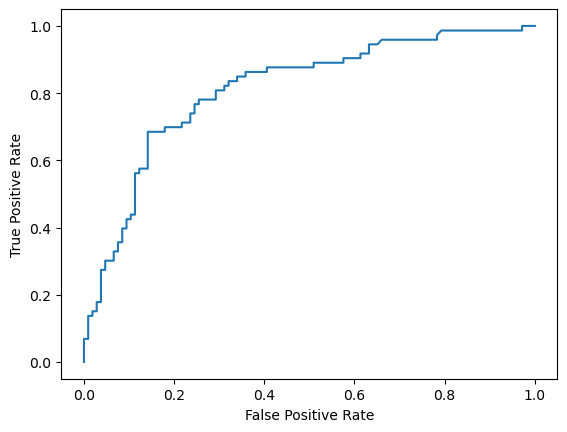

In [12]:
fpr, tpr, thresholds = roc_curve(y_test, yhat_log[:,1]) 
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Try to find the optimal decision threshold
Compute the geometric mean (G-mean) which will find the balance between Sensitivity and Specificity. 

Sensitivity = True Positive Rate \
Specificity = 1 - False Positive Rate

In other words:

Sensitivity (recall) = TP / (TP + FN) \
Specificity = TN / (FP + TN)

To calculate the G-mean, we simply take the square root of the Sensitivity multiplied by the Specificity.

In [14]:
gmeans = np.sqrt(tpr*(1-fpr))

# then find the index with the highest gmean
print("Decision Threshold: ", thresholds[np.argmax(gmeans)])
print("Correctness / geometric mean: ", np.max(gmeans))

Decision Threshold:  0.633769436709823
Correctness:  0.7668162993912869


Note that the same threshold determination can be applied to NB (naives bayes).

In [18]:
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, yhat_nb[:,1])
gmeans_nb = np.sqrt(tpr_nb*(1-fpr_nb))
print("Decision Threshold: ", thresholds_nb[np.argmax(gmeans_nb)])
print("Correctness / geometric mean: ", np.max(gmeans_nb))

Decision Threshold:  0.11659321705830737
Correctness / geometric mean:  0.7597050209063944


Text(0, 0.5, 'True Positive Rate')

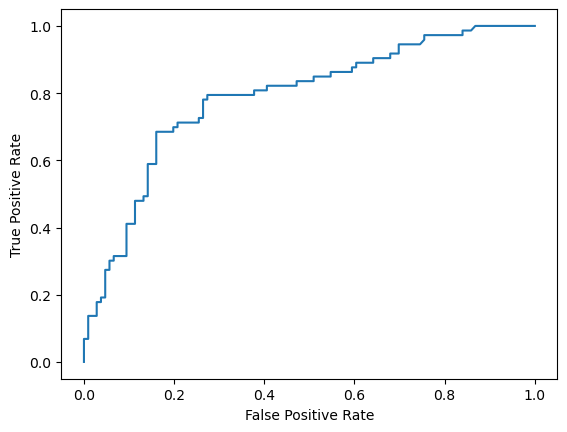

In [16]:
plt.plot(fpr_nb,tpr_nb)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#now let's plot both models (logistic regression and naive bayes) on the same plot so we can see how they compare

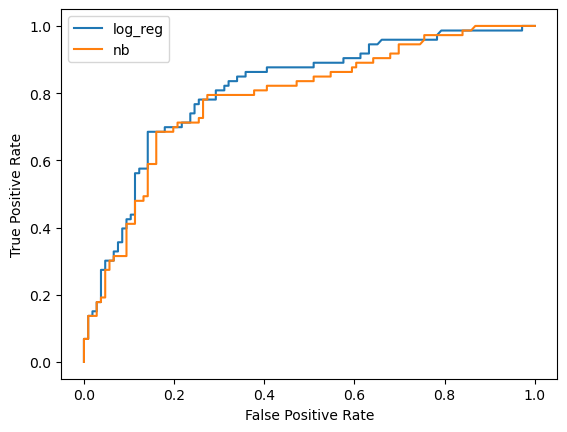

In [19]:
plt.plot(fpr,tpr, label='log_reg')
plt.plot(fpr_nb,tpr_nb, label='nb')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

The Logistic Regression VERY slightly outperforms Naive Bayes for this problem. And once again, we have not done any tuning to these models, but likely we would want to lean towards tho logistic regression.

Now, we **cannot use the same method to evaluate KNN, simply because it's not a probability-based model** (it uses distance). While we want to find the optimal probability threshold for NB or Logistic Regression, for KNN we would be looking for the optimal number of neighbours. 

To compare it to these two models though, we could use the confusion matrix, recall, precision, and F1 score. And the roc_curve which is based on predicted values, rather than probabilities.

# PCA

In [48]:
df_num = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/module_5_feature_engineering_demo.csv')
df_num.drop('Unnamed: 0', axis=1, inplace=True)
df_num

,Height,Weight,Calories_Intake,Exercise_Time,BMI,Age,Resting_Heart_Rate
0,187.640523,81.119254,1733.539473,4.593274,23.039374,70,54.540176
1,174.001572,87.849478,1644.014918,3.568722,29.015686,38,63.510746
2,179.787380,61.553704,2523.067529,2.885513,19.043018,76,49.502603
3,192.408932,72.094281,2020.812760,3.251630,19.473784,35,72.310220
4,188.675580,74.561067,2459.594194,1.789144,20.945017,49,67.864721
...,...,...,...,...,...,...,...
995,174.128708,71.955016,3539.588332,2.496110,23.731234,36,58.531050
996,168.016011,98.030468,2046.267009,4.779559,34.726398,32,63.266300
997,170.941923,73.168677,2403.797896,2.969428,25.039637,20,52.155337
998,158.523891,47.161972,1893.742128,4.577088,18.767331,72,57.429598


#### Standardize the features before applying PCA

Normalization (i.e. MinMaxScaler) is a widely used data preprocessing technique that involves scaling numerical features to fit within a specific range (i.e. [0,1], or [−1,1] if there are negative values) without altering the original feature distributions.

Standardization (i.e. StandardScaler) standardizes the features by removing the mean and scaling them to unit variance,transforming features to normal distributions with a mean of 0 and a standard deviation of 1. 

#### When to Use MinMax Scaler:
Preservation of Zero Values: If 0 has a special meaning in your dataset (e.g., absence of something), MinMax scaling will preserve the zeros.

Non-Gaussian Distributions: If the features do not follow a Gaussian distribution, MinMax scaling might be more appropriate to preserve the original feature distributions

#### When to Use Standard Scaler:
Algorithms Assuming Gaussian Features: Some algorithms, such as SVM with RBF kernel and linear regression, perform better if the features have a normal distribution. 

Outlier Impact: If there are outliers in the data that you don't want to remove completely, Standard Scaler might be a better choice since **MinMax Scaler is more sensitive to outliers**

Feature Interpretability: If you want to maintain the interpretability of features, knowing that a value of "2" means "two standard deviations from the mean" can be more informative.

#### Conclusion
    Use MinMax Scaler when you want to scale features to a specific range, when 0 has a special meaning, or when the distribution is not Gaussian.

    Use Standard Scaler when you want to transform features to have zero mean and unit variance, especially when using algorithms that assume Gaussian distributed features or when you want to reduce the impact of outliers.


In [ ]:
scaler = StandardScaler() # minmaxScaler() scale values from 0 to 1, standard scaler convert data into zero-mean & unit variance
df_std = scaler.fit_transform(df_num) # the numpy array is produced by .fit_transform(). SO you need to convert the data back to dataframe


In [50]:
# note: in data pipeline, you should not use fit_transform, because if new data arrives, you should not 
# train the scaler again but using the pre-trained scaler directly

# Perform PCA
pca = PCA()
df_pca = pca.fit_transform(df_std)

# The transformed data is an array, convert it back into a dataframe
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(len(df_num.columns))])

# Print the explained variance ratio by each PC (Principal Component)
print('Explained variance ratio:', pca.explained_variance_ratio_)

# Print the cumulative explained variance ratio by the PCs
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
print('Cumulative explained variance ratio:', cumsum_variance)

# Show the first few rows of transformed dataframe
df_pca

Explained variance ratio: [0.28857346 0.18072185 0.14675488 0.14381463 0.13558216 0.10353415
 0.00101888]
Cumulative explained variance ratio: [0.28857346 0.46929531 0.61605019 0.75986482 0.89544697 0.99898112
 1.        ]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-0.395268,-1.182948,1.791319,2.336967,0.037477,0.366259,-0.018202
1,0.819082,-0.205962,2.084828,0.028116,-0.058311,0.446441,-0.061576
2,-1.171866,-0.469183,-0.324207,1.639464,-0.240676,-0.935364,0.040073
3,-1.106793,0.798769,2.060352,0.535101,1.421538,0.537776,0.082936
4,-0.772500,1.500282,0.797973,0.753864,1.115887,-0.730499,0.036682
...,...,...,...,...,...,...,...
995,-0.165643,0.099869,-1.340951,-0.602825,1.845622,-0.771032,-0.014003
996,1.886786,-1.170308,1.479227,-0.279721,0.552471,1.200456,-0.024967
997,0.010300,-0.714905,0.840959,-1.300652,0.708702,-0.675074,-0.030753
998,-1.000008,-1.364828,-0.077991,0.531097,-2.030215,1.295974,-0.105292


As shown above, we can drop the last 2 PC to still retain 90% of information / variance within the dataset for the model training

The features are not linearly correlated well so we cannot just use 2 or 3 PC to capture the majority of information (so PCA may not be the best scaler or good pre-processing choice in this case)

Another method to do the same as above (reduce the 2 components by preserving 80% of variance explained):

In [63]:
# Perform PCA
pca = PCA(n_components = 0.80) # you can set it to retain the % of information or get the number of PC by n_components = 2
df_pca = pca.fit_transform(df_std)

# The transformed data is an array, convert it back into a dataframe
df_pca = pd.DataFrame(df_pca)

# Print the explained variance ratio
print('Explained variance ratio:', pca.explained_variance_ratio_)

# Print the cumulative explained variance ratio
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
print('Cumulative explained variance ratio:', cumsum_variance)

# Show the first few rows of transformed dataframe
df_pca.head()

Explained variance ratio: [0.28857346 0.18072185 0.14675488 0.14381463 0.13558216]
Cumulative explained variance ratio: [0.28857346 0.46929531 0.61605019 0.75986482 0.89544697]


,0,1,2,3,4
0,-0.395268,-1.182948,1.791319,2.336967,0.037477
1,0.819082,-0.205962,2.084828,0.028116,-0.058311
2,-1.171866,-0.469183,-0.324207,1.639464,-0.240676
3,-1.106793,0.798769,2.060352,0.535101,1.421538
4,-0.772500,1.500282,0.797973,0.753864,1.115887


# Feature Engineering
Convert the date variable into datetime data format, and/or use 'to_numeric' to convert string into numeric type

In [84]:
bikes = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/bikes_sharing.csv')

# Transform datetime to a datetime data format as pandas assumes 'datetime' to be string at the start
# you need to convert it into datetime manually
bikes['datetime'] = pd.to_datetime(bikes['datetime']) # you can use to_numeric to convert string into numeric type
bikes['datetime']

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
10881   2012-12-19 19:00:00
10882   2012-12-19 20:00:00
10883   2012-12-19 21:00:00
10884   2012-12-19 22:00:00
10885   2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: datetime64[ns]

In [85]:
# Extract hour, month, day into new columns
# get the hour in 24hr format
bikes['hour'] = bikes['datetime'].dt.hour

# get the month
bikes['month'] = bikes['datetime'].dt.month

# get day of month
bikes['day'] = bikes['datetime'].dt.day
bikes

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19,12,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20,12,19
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21,12,19
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22,12,19


Create a function to categorize the numeric variables (convert numeric variable into categorical variable)

In [87]:
def total_cat(x):
    if x >= 0 and x < 10:
        return '0-10'
    elif x >= 10 and x < 50:
        return '10-50'
    elif x >= 50 and x < 100:
        return '50-100'
    else:
        return '100+'

# Create new column with rental count range using total_cat() function created above

bikes['rental_total_group'] = bikes['count'].apply(total_cat)
# this .apply() apples 'total_cat' function to each value in the bikes['count'] series
bikes['rental_total_group']

0         10-50
1         10-50
2         10-50
3         10-50
4          0-10
          ...  
10881      100+
10882      100+
10883      100+
10884      100+
10885    50-100
Name: rental_total_group, Length: 10886, dtype: object

### Motivation to convert numeric variable into categorical variables
Simplicity and Interpretability: Categorical representations can simplify complex numeric patterns and make the data more interpretable.

Handling Outliers: Binning can make the model less sensitive to the outliers within specific features, reducing the influence of extreme feature values.

Statistical Power: If a dataset has sparse data across a wide numeric range, binning can help in combining these sparse data points into meaningful groups, potentially increasing the statistical power of tests or models.

Non-linear Relationships: Binning can help in capturing non-linear relationships between a numeric variable and the target variable.

In some cases, models might perform better when numeric variables are binned, especially if there's a strong non-linear relationship between the numeric variable and the target variable. (i.e. **linear model like logistic regression and linear SVM** as binning numeric variables enables the model to capture non-linear relationship between the binned variable and the target variable (after one-hot encoding the binned variable), **distance-based algorithms like K-NN** (if the scale of numeric variables varies widely, binning ensures that the distance metric isn't dominated by variables with larger scales. Moreover, if there's a non-linear pattern in the data, binned variables might create more distinct clusters of similar observations))

*Capturing Non-linear Effects: The logistic regression model is linear in its parameters. However, by creating these binary variables from binned numeric data, you allow the model to assign different weights (coefficients) to different intervals (bins) of the original numeric variable. This can effectively capture non-linear relationships between the binned numeric feature and the outcome.*

In [88]:
# Create function with 2 inputs - temp and humidity - to classify good/bad days
def good_bad(temp,hum):
    if temp > 25 and hum > 70:
        return 'too hot'
    elif temp <=25 and hum >= 50 and hum <= 70:
        return 'so so day'
    else:
        return 'good day'

# when .apply() functions accepts 2 or more arguments, 
# and you use .apply on dataframe directly (not on series), you need to use lambda

bikes['day_type'] = bikes.apply(lambda x: good_bad(x['temp'], x['humidity']), axis=1) 
# the x in 'lambda x' refers to 'bikes' (the dataframe)
# axis = 1 means the function will look for 'temp' and 'humidity' horizontally, rather than vertically on the rows

bikes['day_type']

0         good day
1         good day
2         good day
3         good day
4         good day
           ...    
10881    so so day
10882    so so day
10883    so so day
10884    so so day
10885    so so day
Name: day_type, Length: 10886, dtype: object

In [89]:
# Dummy variables - convert season to dummies; first - rename season

season_mapping = {1:'winter', 2:'spring', 3:'summer', 4:'fall'}
bikes['season'] = bikes['season'].map(season_mapping) # replace feature values by using dictionary
# note: map will give nan to a unspecified value. 
# make sure your map dictionary covers all unique values in the feature


Create dummy variables

In [100]:
season_dummies = pd.get_dummies(bikes['season'], dtype=int)
# concatenate horizontally
bikes = pd.concat([bikes,season_dummies], axis=1)
bikes.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,hour,month,day,rental_total_group,day_type,fall,spring,summer,winter
0,2011-01-01 00:00:00,winter,0,0,1,9.84,14.395,81,0.0,3,...,16,0,1,1,10-50,good day,0,0,0,1
1,2011-01-01 01:00:00,winter,0,0,1,9.02,13.635,80,0.0,8,...,40,1,1,1,10-50,good day,0,0,0,1
2,2011-01-01 02:00:00,winter,0,0,1,9.02,13.635,80,0.0,5,...,32,2,1,1,10-50,good day,0,0,0,1
3,2011-01-01 03:00:00,winter,0,0,1,9.84,14.395,75,0.0,3,...,13,3,1,1,10-50,good day,0,0,0,1
4,2011-01-01 04:00:00,winter,0,0,1,9.84,14.395,75,0.0,0,...,1,4,1,1,0-10,good day,0,0,0,1


In [99]:
# another ex to bin numerical variable
# find valueable customer if they buy a lot and spend highly (above 75% customer)
def good_bad_c(purchase,spent):
    if purchase > 38 and spent > 1480:
        return 'value customer'
    else:
        return 'ok customer'

df['customer_type'] = df.apply(lambda x: good_bad_c(x['total_purchases'], x['total_spent']), axis=1) 
# axis must be 1 to tell that 'total_purchases' in x['total_purchases'] is refering to the column not the row

# visualize distribution
df['customer_type'].value_counts().plot(kind='bar')

# Linear Regression

In [40]:
bikes = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/bikes_sharing.csv')
x = bikes['temp']
y = bikes['casual']


43% (indicated by the R-squared) of the dependent variable values are explained by the independent variables (features), implying that the 4 training features are all important features to preditc the target feature as p<0.05
  

In [41]:
results = ols("casual ~ temp + humidity + workingday", data=bikes).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     2766.
Date:                Tue, 08 Aug 2023   Prob (F-statistic):               0.00
Time:                        00:32:21   Log-Likelihood:                -54939.
No. Observations:               10886   AIC:                         1.099e+05
Df Residuals:                   10882   BIC:                         1.099e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     53.1426      1.663     31.961      0.0

In [44]:
# Get the residual error (res['error'])
print("residual error: \n",results.resid)

# Get the root MSE
np.sqrt(results.mse_resid)

residual error: 
 0       -11.175362
1        -4.612922
2        -7.612922
3       -16.194189
4       -19.194189
           ...    
10881   -13.856745
10882    -2.602536
10883    -2.857740
10884     5.142260
10885     3.723526
Length: 10886, dtype: float64


37.63789221370789

# stacking (or stacked generalization), 

the idea is to use predictions from several base models as input features for a final estimator (often called a meta-model or meta-learner) that predicts the target variable. The choice of the final estimator is crucial, as it determines how the predictions from the base models are combined.

The best suitable final estimator often depends on the problem at hand, the nature of the base models, and the dataset. However, here are some considerations:

Linear Models (e.g., Linear Regression, Logistic Regression):

Why: If the base models are diverse and their predictions are roughly of equal quality, a simple linear model can be effective as a final estimator. It will learn to assign weights to the predictions of the base models.
Advantage: Easy to interpret and less prone to overfitting.

Decision Trees and Tree-based Ensembles (e.g., Decision Tree, Random Forest, Gradient Boosting Machines):

Why: If there are complex interactions between the predictions of the base models, tree-based methods can capture them.
Advantage: Can model non-linear relationships and interactions between base model predictions.

K-Nearest Neighbors (K-NN):

Why: Useful when predictions from base models cluster in the feature space in a way that's indicative of the target.
Advantage: Makes no assumptions about the functional form of the combination.
Disadvantage: Computationally expensive, especially with large stacked datasets.

Regularized Regression (e.g., Ridge, Lasso):

Why: When using a large number of base models, regularized regression can help in selecting or giving more weight to the more useful predictions.
Advantage: Can prevent overfitting when there are many base model predictions.
